In [1]:
from os import listdir
from os.path import join
import pickle
import pandas as pd
import numpy as np
from scipy.stats import zscore
from scipy.stats import pearsonr
from scipy.optimize import curve_fit
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sgt.sgt import SGT
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import colors
import seaborn as sns
from tqdm.notebook import tqdm

c:\Users\mikeo\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\mikeo\anaconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Users\mikeo\anaconda3\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
plt.rc('font', size=9)          # controls default text sizes
plt.rc('axes', titlesize=9)     # fontsize of the axes title
plt.rc('axes', labelsize=9)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=8)    # fontsize of the tick labels
plt.rc('ytick', labelsize=8)    # fontsize of the tick labels
plt.rc('legend', fontsize=9)    # legend fontsize
plt.rc('figure', titlesize=9)  # fontsize of the figure title

In [3]:
df = pd.read_csv('./output/netMHCpan/NetMHCpan-output_labeled.csv', index_col=[0], dtype=str)
df.HLA_type = [x.split('-')[1][0] + '*' + x.split('-')[1][1:] for x in df.HLA_type]
df['Count'] = [1]*len(df)
tested = df[(df.IEDB.isna() == False)]
untested = df[df.IEDB.isna()]

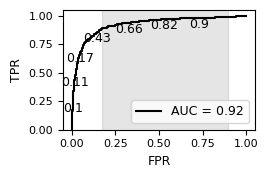

In [4]:
fig, ax = plt.subplots(figsize=(2.65, 1.85))
y = []
for i in tested.IEDB:
    if i == 'False':
        y.append(0)
    else:
        y.append(1)
el_scores = tested['EL-score']
ba_scores = tested['BA-score']

X = np.array([el_scores.values, ba_scores.values]).T
logit = LogisticRegression(random_state=0).fit(X, y)
y_pred = logit.predict_proba(X)[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y, y_pred, pos_label=1)
ax.plot(fpr, tpr, label='AUC = ' + str(round(metrics.auc(fpr, tpr), 2)), c='k')

count = 0
points = [(0, 0), (1, 1)]
for i, j, k in zip(fpr, tpr, thresholds[::-1]):
    mindist = 1
    for p in points:
        d = np.sqrt(np.abs(i - p[0])**2 + np.abs(j - p[1])**2)
        if d < mindist:
            mindist = d
    if mindist > 0.2:
        ax.text(i, j, round(k, 2), verticalalignment='top', c='k', horizontalalignment='center')
        points.append((i, j))
x0 = np.absolute(thresholds[::-1] - 0.5).argmin()
x1 = np.absolute(thresholds[::-1] - 0.95).argmin()
ax.fill_between([fpr[x0], fpr[x1]], -1, 2, color='grey', alpha=0.2)
ax.set_ylim([-0.0, 1.05])
ax.set_xlim([-0.05, 1.05])
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
ax.legend()
plt.tight_layout()
plt.savefig('images/Figure1E.svg')
plt.show()
plt.close()

In [6]:
df['Probability'] = logit.predict_proba(df[['EL-score', 'BA-score']].values)[:, 1]
tested = df[(df.IEDB.isna() == False)]
untested = df[df.IEDB.isna()]

C:\Users\mikeo\AppData\Local\Temp\ipykernel_13220\785719209.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tested.loc[:, 'Validated'] = tested.IEDB != 'False'
C:\Users\mikeo\AppData\Local\Temp\ipykernel_13220\785719209.py:69: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


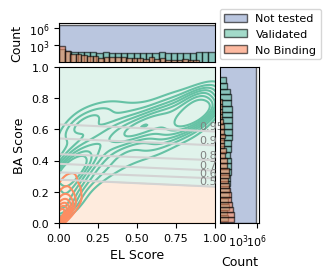

In [7]:
def linear(x, m, b):
    return m * x + b

tested.loc[:, 'Validated'] = tested.IEDB != 'False'
pos = tested.loc[tested.Validated == True].copy()
neg = tested.loc[tested.Validated == False].copy()
pos.loc[:, 'EL-score'] = pd.to_numeric(pos['EL-score'])
neg.loc[:, 'EL-score'] = pd.to_numeric(neg['EL-score'])
pos.loc[:, 'BA-score'] = pd.to_numeric(pos['BA-score'])
neg.loc[:, 'BA-score'] = pd.to_numeric(neg['BA-score'])

points_x = [x/10. for x in range(-50,+50)]
line_bias = logit.intercept_
line_w = logit.coef_.T
points_y = [(line_w[0][0]*x+line_bias[0])/(-1*line_w[1][0]) for x in points_x]

colors1 = plt.get_cmap('Set2').colors
colors2 = plt.get_cmap('Pastel2').colors

fig = plt.figure(figsize=(2.5, 2.5))

gs = fig.add_gridspec(2, 2, width_ratios=(4, 1), height_ratios=(1, 4), 
                      left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.05, hspace=0.05)
ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0])
ax_histy = fig.add_subplot(gs[1, 1])

ax.fill_between(points_x, points_y, [1]*len(points_y), color=colors2[0], alpha=0.4)
ax.fill_between(points_x, points_y, [0]*len(points_y), color=colors2[1], alpha=0.4)
sns.kdeplot(data=pos, x="EL-score", y="BA-score", fill=False, bw_adjust=1, color=colors1[0],
            levels=8, thresh=.2, alpha=1., ax=ax)
sns.kdeplot(data=neg, x="EL-score", y="BA-score", fill=False, bw_adjust=1, color=colors1[1],
            levels=8, thresh=.2, alpha=1., ax=ax)

for cutoff in np.append(np.arange(0.5, 1., 0.1), np.array([0.95])):
    tmp = tested.loc[(tested.Probability < cutoff + .01) & (tested.Probability > cutoff - .01)]
    x, y = pd.to_numeric(tmp['EL-score']), pd.to_numeric(tmp['BA-score'])
    popt, pcov = curve_fit(linear, x, y)
    xfit = np.arange(0, 2, .1)
    ax.plot(xfit, linear(xfit, *popt), c='lightgrey')
    ax.text(0.9, linear(1, *popt)+.015, str(round(cutoff, 2)), c='grey', fontsize=8)
    
ax.set_ylim([0, 1])
ax.set_xlim([0, 1])
ax.set_xlabel('EL Score')
ax.set_ylabel('BA Score')

bins = 25
ax_histx.hist(untested['EL-score'], color=colors1[2], alpha=0.6, bins=bins, edgecolor='k')
ax_histx.hist(pos['EL-score'], color=colors1[0], alpha=0.6, bins=bins, edgecolor='k')
ax_histx.hist(neg['EL-score'], color=colors1[1], alpha=0.6, bins=bins, edgecolor='k')
ax_histx.set_xlim([0, 1])
ax_histx.set_yscale('log')
ax_histx.set_ylabel('Count')
ax_histx.set_xticks([])
ax_histx.set_yticks([1e3, 1e6])

ax_histy.hist(untested['BA-score'], color=colors1[2], alpha=0.6, bins=bins, edgecolor='k', orientation='horizontal', label='Not tested')
ax_histy.hist(pos['BA-score'], color=colors1[0], alpha=0.6, bins=bins, edgecolor='k', orientation='horizontal', label='Validated')
ax_histy.hist(neg['BA-score'], color=colors1[1], alpha=0.6, bins=bins, edgecolor='k', orientation='horizontal', label='No Binding')
ax_histy.set_ylim([0, 1])
ax_histy.set_xscale('log')
ax_histy.set_xlabel('BA Score')
ax_histy.set_xlabel('Count')
ax_histy.set_yticks([])
ax_histy.set_xticks([1e3, 1e6])

plt.legend(loc=[0, 1.05], fontsize=8)
plt.tight_layout()
plt.savefig('images/Figure1D.svg')
plt.show()
plt.close()

In [8]:
pdict = {}
prange = np.arange(0.5, 0.95, 0.01)
for tq, i in zip(tqdm(prange), prange):
    untested_copy = untested.copy()
    untested_copy.HLA_type = [x.split('*')[0] for x in untested_copy.HLA_type]
    tmp = untested_copy[(untested_copy.Probability >= i)].groupby(['HLA_type', 'Protein']).sum()
    for x in tmp.index:
        if x in pdict:
            pdict[x].append(tmp.loc[x].Count)
        else:
            pdict[x] = [tmp.loc[x].Count]

  0%|          | 0/45 [00:00<?, ?it/s]

In [ ]:
tsum = tested[(tested.Validated == True)].groupby('HLA_type').sum().sort_values('HLA_type')
ax_sizes = [(2, 4.25), (2, 6.75), (2, 3.5)]
for ix, gene in enumerate(['A', 'B', 'C']):
    alleles, umean, ustd, t = [], [], [], []
    for allele in list(pdict):
        if gene in allele:
            alleles.append(allele)
            umean.append(np.mean(pdict[allele]))
            ustd.append(np.std(pdict[allele]))
            if allele in tsum.index:
                t.append(tsum.loc[allele].Count)
            else:
                t.append(0)
    o = pd.DataFrame({'Allele' : alleles, 'Validated' : t, 'Mean' : umean, 'Std' : ustd}).sort_values('Mean', ascending=False)
    fig, ax = plt.subplots(figsize=ax_sizes[ix])
    ax.barh(o.Allele, o.Validated, left=0.5, color=colors1[0], edgecolor='k', alpha=0.6, height=0.8, label='Validated')
    ax.barh(o.Allele, o.Mean, left=0.5+o.Validated, color=colors1[2], xerr=o.Std, capsize=2, height=0.8,
        edgecolor='k', alpha=0.6, label='Not tested')
    #plt.xticks(rotation=90)
    plt.ylim([-1, len(o)])
    plt.xlabel('Count (#)')
    plt.xscale('log')
    #plt.legend()
    plt.tight_layout()
    plt.savefig('images/Figure1' + gene + '.svg')
    plt.show()
    plt.close()

C:\Users\mikeo\AppData\Local\Temp\ipykernel_3816\2465617697.py:55: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


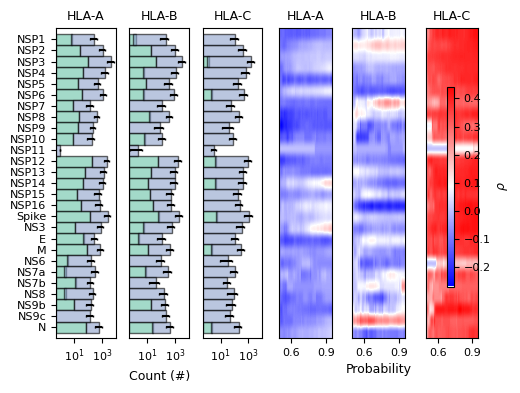

In [ ]:
order_dict = {'NSP1' : 0, 'NSP2': 1, 'NSP3' : 2, 'NSP4' : 3, 'NSP5' : 4, 'NSP6' : 5, 'NSP7' : 6, 'NSP8' : 7, 'NSP9' : 8,
              'NSP10' : 9, 'NSP11' : 10, 'NSP12' : 11, 'NSP13' : 12, 'NSP14' : 13, 'NSP15' : 14, 'NSP16' : 15, 'Spike' : 16,
              'NS3' : 17, 'E' : 18, 'M' : 19, 'NS6' : 20, 'NS7a' : 21, 'NS7b' : 22, 'NS8' : 23, 'NS9b' : 24, 'NS9c' : 25, 'N' : 26}

fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6, figsize=(5, 4))
for gene, ax in zip(['A', 'B', 'C'], [ax1, ax2, ax3]):
    tested['Gene'] = [x.split('\*')[0] for x in tested.HLA_type]
    #tsum = tested[(tested.Validated == True) & (tested.HLA_type.str.contains(gene))].drop_duplicates(['Peptide', 'Protein', 'Gene']).groupby('Protein').sum().sort_values('Protein')
    tsum = tested[(tested.Validated == True) & (tested.HLA_type.str.contains(gene))][['Protein', 'Count']].groupby('Protein').sum().sort_values('Protein', ascending=False)
    proteins, umean, ustd, t = [], [], [], []
    gene_dict = {}
    for entry in list(pdict):
        if gene in entry[0]:
            if entry[1] in gene_dict:
                gene_dict[entry[1]] = gene_dict[entry[1]] + pdict[entry]
            else:
                gene_dict[entry[1]] = pdict[entry]
    for prot in gene_dict:
        proteins.append(prot)
        umean.append(np.mean(gene_dict[prot]))
        ustd.append(np.std(gene_dict[prot]))
        if prot in tsum.index:
            t.append(tsum.loc[prot].Count)
        else:
            t.append(0)
    o = pd.DataFrame({'Protein' : proteins, 'Validated' : t, 'Mean' : umean, 'Std' : ustd}).sort_values(by=['Protein'], key=lambda x: x.map(order_dict), ascending=False)
    ax.barh(o.Protein, o.Validated, height=1, color=colors1[0], left=0.5, edgecolor='k', alpha=0.6)
    ax.barh(o.Protein, o.Mean, left=o.Validated, color=colors1[2], xerr=o.Std, capsize=1,
           height=1, edgecolor='k', alpha=0.6)
    ax.set_xscale('log')
    ax.set_xlim([5e-1, 1e4])
    ax.set_xticks([1e1, 1e3])
    ax.set_ylim([-1, 27])
    ax.set_title('HLA-' + gene)
ax2.set_yticks([])
ax3.set_yticks([])
#ax1.set_xlabel('HLA-A (#)')
ax2.set_xlabel('Count (#)')
#ax3.set_xlabel('HLA-C (#)')
plt.xticks(rotation=0)

genes = ['A', 'B', 'C']
C = np.nan_to_num(np.array(C))
for i, ax in enumerate([ax4, ax5, ax6]):
    im = ax.imshow(C[i, ::-1, :].T, cmap='bwr', aspect=10, vmin=np.min(C), vmax=np.max(C))
    ax.set_title('HLA-' + genes[i])
    ax.set_xticks([10, 40])
    ax.set_xticklabels([0.6, 0.9])
    ax.set_yticks([])

ax5.set_xlabel('Probability')
cbar_ax = fig.add_axes([0.9, 0.275, 0.015, 0.5])
fig.colorbar(im, cax=cbar_ax, label=r'$\rho$')
#cbar_ax.set_title(r'$\rho$')
plt.tight_layout()
plt.savefig('images/Figure3AB.svg')
plt.show()
plt.close()

In [9]:
def calc_overlap(x, c):
    dup = pd.Series(np.append(x, c)).duplicated()
    return len(dup[dup == True]) / len(x) * 100

aoverlap, boverlap = [], []
probabilities = np.arange(0.5, 0.96, 0.01)
venn_dict = {}
for tq, p in zip(tqdm(range(len(probabilities))), probabilities):
    A = df[(df.HLA_type.str.contains('A')) & (df.Probability >= p)].sort_values('Peptide').Peptide.unique()
    B = df[(df.HLA_type.str.contains('B')) & (df.Probability >= p)].sort_values('Peptide').Peptide.unique()
    C = df[(df.HLA_type.str.contains('C')) & (df.Probability >= p)].sort_values('Peptide').Peptide.unique()
    aoverlap.append(calc_overlap(A, C))
    boverlap.append(calc_overlap(B, C))
    venn_dict[round(p, 2)] = [set(A), set(B), set(C)]
    
overlap_df = pd.DataFrame(data = {'Probability' : probabilities, 'A' : aoverlap, 'B' : boverlap})

  0%|          | 0/46 [00:00<?, ?it/s]

In [12]:
class nestedDict(dict):
    def __missing__(self, key):
        value = self[key] = type(self)()
        return value

def filter_interactions(baf, elf, path, model):
    ba = pd.read_pickle(join(path, baf))
    if len(ba) > 0:
        el = pd.read_pickle(join(path, elf))
        protein = baf.split('_')[0]
        ba_filtered = ba[ba >= 0.1].dropna(how='all').T.dropna(how='all')
        el_filtered = el[el >= 0.1].dropna(how='all').T.dropna(how='all')
        if len(ba_filtered) > 0 and len(el_filtered) > 0:
            ba_filtered = ba_filtered.T.stack().dropna(how='all').stack().dropna(how='all').stack().dropna(how='all').stack().dropna()
            el_filtered = el_filtered.T.stack().dropna(how='all').stack().dropna(how='all').stack().dropna(how='all').stack().dropna()
            out = pd.DataFrame(ba_filtered, columns=['BA']).merge(pd.DataFrame(el_filtered, columns=['EL']), left_index=True, right_index=True).dropna().droplevel(4).reset_index()[['residues', 'peptide', 'mutation', 'allele', 'BA', 'EL']].drop_duplicates()
            out.columns = ['residues', 'Peptide Sequence', 'Mutation', 'Allele', 'BA', 'EL']
            start = [x[0]+1 for x in out.residues]
            stop = [x[1]+1 for x in out.residues]
            out['Residue Start'] = start
            out['Residue Stop'] = stop
            out['Protein'] = [protein]*len(out)
            out['Probability'] = model.predict_proba(out[['EL', 'BA']].values)[:, 1]
            out = out[out.Probability >= 0.5]
        else:
            out = pd.DataFrame()
    else:
        out = pd.DataFrame()
    return out

data = pd.read_csv(join('input', 'data.csv'))

with open('./input/UM_mutation_dict.pkl', 'rb') as file:
    muts = pickle.load(file)

MASTER = pd.DataFrame()
ba_files = [x for x in listdir('./output/netMHCpan/pkl') if 'BA.pkl' in x]
el_files = [x.replace('BA', 'EL') for x in ba_files]
for tq, baf, elf in zip(tqdm(range(len(ba_files))), ba_files, el_files):
    out = filter_interactions(baf, elf, './output/netMHCpan/pkl', logit)
    if len(out) > 0 and MASTER.empty:
        MASTER = out[['Allele', 'Protein', 'Mutation', 'Residue Start', 'Residue Stop', 'Peptide Sequence', 'EL', 'BA', 'Probability']]
    elif len(out) > 0:
        MASTER = pd.concat([MASTER, out[['Allele', 'Protein', 'Mutation', 'Residue Start', 'Residue Stop', 'Peptide Sequence', 'EL', 'BA', 'Probability']]])
        
for c in data.columns:
    if '-' in c:
        new = []
        for v in data[c]:
            if isinstance(v, str):
                new.append(':'.join(v.strip(' ').split(' ')[0].split(':')[:2]).split('(')[0].strip('Q'))
            else:
                new.append('')
        data[c] = new

sample_dict = {}
for tq, row1 in zip(tqdm(range(len(data))), data.iterrows()):
    sample_df = pd.DataFrame()
    sid = row1[1].SAMPLE_ID
    gisaid = row1[1].gisaid_epi_isl
    alleles = [row1[1]['A-1'], row1[1]['A-2'], row1[1]['B-1'], row1[1]['B-2'], row1[1]['C-1'], row1[1]['C-2'], row1[1]['DR-1'], row1[1]['DR-2']]
    for p in muts[gisaid]:
        m = muts[gisaid][p]
        for a in alleles:
            tmp = MASTER[(MASTER.Allele == a) & (MASTER.Protein == p) & (MASTER.Mutation.isin(['WT'] + m))]
            duplicated = tmp[tmp['Peptide Sequence'].duplicated()]['Peptide Sequence'].unique()
            for d in duplicated:
                if len(tmp[tmp['Peptide Sequence'] == d].Mutation.unique()) > 1:
                    tmp = tmp.drop(tmp[((tmp['Peptide Sequence'] == d) & (tmp.Mutation == 'WT'))].index.values)
            if sample_df.empty:
                sample_df = tmp
            else:                  
                sample_df = pd.concat([sample_df, tmp])
    sample_dict[sid] = sample_df

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

In [13]:
for c in data.columns:
    if '-' in c:
        new = []
        for v in data[c]:
            if isinstance(v, str):
                new.append(':'.join(v.strip(' ').split(' ')[0].split(':')[:2]).split('(')[0].strip('Q'))
            else:
                new.append('')
        data[c] = new

sample_dict = {}
for tq, row1 in zip(tqdm(range(len(data))), data.iterrows()):
    sample_df = pd.DataFrame()
    sid = row1[1].SAMPLE_ID
    gisaid = row1[1].gisaid_epi_isl
    alleles = [row1[1]['A-1'], row1[1]['A-2'], row1[1]['B-1'], row1[1]['B-2'], row1[1]['C-1'], row1[1]['C-2']]
    for p in muts[gisaid]:
        m = muts[gisaid][p]
        for a in alleles:
            tmp = MASTER[(MASTER.Allele == a) & (MASTER.Protein == p) & (MASTER.Mutation.isin(['WT'] + m))]
            duplicated = tmp[tmp['Peptide Sequence'].duplicated()]['Peptide Sequence'].unique()
            for d in duplicated:
                if len(tmp[tmp['Peptide Sequence'] == d].Mutation.unique()) > 1:
                    tmp = tmp.drop(tmp[((tmp['Peptide Sequence'] == d) & (tmp.Mutation == 'WT'))].index.values)
            sample_df = pd.concat([sample_df, tmp])
    sample_dict[sid] = sample_df

  0%|          | 0/60 [00:00<?, ?it/s]

In [14]:
columns = ['ID', 'Probability', 'SOFA', 'A', 'B', 'C', 'Sex', 'Age', 'BMI']
Rz, R1z, R2z = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
R1 = pd.DataFrame()
for tq, i in zip(tqdm(range(len(np.arange(0.5, 1., 0.01)))), np.arange(0.5, 1., 0.01)):
    reg_data = []
    for row in data.iterrows():
        out = [row[1].SAMPLE_ID, i, row[1][-1]]
        for gene in ['A\*', 'B\*', 'C\*']:
            tmp = sample_dict[row[1][0]]
            out.append(len(tmp[(tmp.Allele.str.contains(gene)) & (tmp.Probability >= i)]))
        if 'Female' in row[1].SEX:
            out.append(1)
        else:
            out.append(0)
        out.append(row[1].AGE)
        out.append(row[1].BMI)
        reg_data.append(out)

    regdf1 = pd.DataFrame(data=reg_data, columns=columns)
    if regdf1.sum(axis=0)[1:].min() > 0:
        R1 = pd.concat([R1, regdf1])
        for c in regdf1.columns[3:]:
            regdf1[c] = zscore(regdf1[c])
        R1z = pd.concat([R1z, regdf1])

R1z.to_csv('R1z.csv', index=False)

  0%|          | 0/50 [00:00<?, ?it/s]

In [15]:
data = pd.read_csv(join('input', 'data.csv'))
columns = ['ID', 'Probability', 'SOFA']
for p in ['S', 'N']:
    for l in ['A', 'B', 'C']:
            columns.append(l + '_' + p)
columns = columns + ['Sex', 'Age', 'BMI']
Rp = pd.DataFrame()
for tq, i in zip(tqdm(range(len(np.arange(0.5, 1., 0.01)))), np.arange(0.5, 1., 0.01)):
    reg_data = []
    for row in data.iterrows():
        out = [row[1].SAMPLE_ID, i, row[1][-1]]
        tmp = sample_dict[row[1][0]]
        cat = []
        for p in tmp.Protein:
            if p in ['E', 'M', 'N', 'Spike']:
                cat.append('Structural')
            else:
                cat.append('Nonstructural')
        tmp['Category'] = cat
        for prot in ['Structural', 'Nonstructural']:
            for gene in ['A\*', 'B\*', 'C\*']:
                tmp2 = tmp[tmp.Category == prot]
                out.append(len(tmp2[(tmp2.Allele.str.contains(gene)) & (tmp2.Category == prot) & (tmp2.Probability >= i)]))
        if 'Female' in row[1].SEX:
            out.append(1)
        else:
            out.append(0)
        out.append(row[1].AGE)
        out.append(row[1].BMI)
        reg_data.append(out)
    regdf1 = pd.DataFrame(data=reg_data, columns=columns)
    if regdf1.sum(axis=0)[1:].min() > 0:
        for c in regdf1.columns[3:]:
            regdf1[c] = zscore(regdf1[c])
        Rp = pd.concat([Rp, regdf1])

Rp.to_csv('Rp.csv', index=False)

  0%|          | 0/50 [00:00<?, ?it/s]

In [16]:
correlation_dict = nestedDict()
for tq, row in zip(tqdm(range(len(data))), data.iterrows()):
    sample = row[1].SAMPLE_ID
    sofa = row[1].HIGHEST_SOFA_10DAY
    correlation_dict[sample]['SOFA'] = sofa
    data = sample_dict[sample]
    for gene in ['A', 'B', 'C']:
        for protein in data.Protein.unique():
            for cutoff in np.arange(0.5, 0.95, 0.01):
                n = len(data[(data.Allele.str.contains(gene)) & (data.Protein == protein) & (data.Probability >= cutoff)])
                correlation_dict[sample][gene][protein][cutoff] = n

  0%|          | 0/60 [00:00<?, ?it/s]

In [17]:
C = []
samples = list(correlation_dict)
proteins = ['NSP1', 'NSP2', 'NSP3', 'NSP4', 'NSP5', 'NSP6', 'NSP7', 'NSP8', 'NSP9', 'NSP10', 'NSP11', 'NSP12', 'NSP13', 'NSP14', 'NSP15', 'NSP16', 'Spike',
              'NS3', 'E', 'M', 'NS6', 'NS7a', 'NS7b', 'NS8', 'NS9b', 'NS9c', 'N']
for gene in ['A', 'B', 'C']:
    g = []
    for cutoff in np.arange(0.5, 0.96, 0.01):
        c = []
        for protein in proteins:
            tmp = [correlation_dict[s][gene][protein][cutoff] for s in list(samples)]
            x = []
            for t in tmp:
                if isinstance(t, int) == False:
                    x.append(0)
                else:
                    x.append(t)
            y = [correlation_dict[s]['SOFA'] for s in list(samples)]
            c.append(pearsonr(x, y)[0])
        g.append(c)
    C.append(g)

c:\Users\mikeo\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


In [19]:
proteins = ['NSP1', 'NSP2', 'NSP3', 'NSP4', 'NSP5', 'NSP6', 'NSP7', 'NSP8', 'NSP9', 'NSP10', 'NSP11', 'NSP12', 'NSP13', 'NSP14', 'NSP15', 'NSP16', 'Spike',
              'NS3', 'E', 'M', 'NS6', 'NS7a', 'NS7b', 'NS8', 'NS9b', 'NS9c', 'N']
pd.DataFrame(data={'Protein' : proteins, 'Corr' : C[1, ::-1, :].T.mean(axis=1) + C[1, ::-1, :].T.std(axis=1)}).sort_values('Corr', ascending=True)

,Protein,Corr
15,NSP16,-0.149184
5,NSP6,-0.112900
26,N,-0.068670
11,NSP12,-0.061599
20,NS6,-0.040199
4,NSP5,-0.040148
13,NSP14,-0.036950
17,NS3,-0.036794
8,NSP9,-0.032118
9,NSP10,-0.026135


In [20]:
overlap_dict = nestedDict()
for tq, s in zip(tqdm(range(len(sample_dict))), list(sample_dict)):
    d = sample_dict[s]
    for p in np.arange(0.5, 0.96, 0.01):
        al = list(d[(d.Allele.str.contains('A')) & (d.Probability >= p)]['Peptide Sequence'])
        bl = list(d[(d.Allele.str.contains('B')) & (d.Probability >= p)]['Peptide Sequence'])
        cl = list(d[(d.Allele.str.contains('C')) & (d.Probability >= p)]['Peptide Sequence'])
        oa, ob, oab = 0, 0, 0
        for ci in cl:
            if ci in al and ci in bl:
                oab += 1
            elif ci in al:
                oa += 1
            elif ci in bl:
                ob += 1
        overlap_dict[s][round(p, 2)]['AB'] = oab
        overlap_dict[s][round(p, 2)]['A'] = oa
        overlap_dict[s][round(p, 2)]['B'] = ob
        overlap_dict[s][round(p, 2)]['AB_total'] = len(al) + len(bl)
        overlap_dict[s][round(p, 2)]['A_total'] = len(al)
        overlap_dict[s][round(p, 2)]['B_total'] = len(bl)

  0%|          | 0/60 [00:00<?, ?it/s]

In [21]:
with open('sample_dict.pkl', 'wb') as out:
    pickle.dump(sample_dict, out)

In [23]:
#data = pd.read_csv(join('input', 'data.csv'))
#samples = list(overlap_dict)
#sofa = [data[data.SAMPLE_ID == s].HIGHEST_SOFA_10DAY.values[0] for s in samples]
#pcor_dict = nestedDict()
#peptides = df[(df.Probability >= 0.5) & (df.HLA_type.str.contains('C'))].Peptide.unique()
for tq, peptide in zip(tqdm(range(len(peptides[4064:]))), peptides[4064:]):
    name = ''
    for p in np.arange(0.5, 0.96, 0.01):
        xval = []
        for s in samples:
            tmp = sample_dict[s]
            tmp = tmp[(tmp['Peptide Sequence'] == peptide) & (tmp['Probability'] >= p)]
            xval.append(len(tmp))
            if len(tmp) > 0:
                name = tmp.Protein.values[0] + ' ' + tmp.Mutation.values[0] + ' ' + str(tmp['Residue Start'].values[0]) + ' ' + str(tmp['Residue Stop'].values[0]) + ' ' + tmp['Peptide Sequence'].values[0]
        pcor_dict[name][round(p, 2)] = pearsonr(xval, sofa)[0]

  0%|          | 0/1049 [00:00<?, ?it/s]

c:\Users\mikeo\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


In [24]:
pcor_df = pd.DataFrame(pcor_dict).replace(np.nan, 0.).T

In [25]:
pcor_df['Mean'] = pcor_df.mean(axis=1)
pcor_df['Std'] = pcor_df.std(axis=1)

In [26]:
pcor_df = pcor_df.sort_values('Mean', ascending=False)

In [27]:
pcor_df['MS'] = pcor_df.Mean - pcor_df.Std

In [28]:
sigCorr = pcor_df #[pcor_df.MS >= 0.25]

In [29]:
protein = [x.split(' ')[0] for x in sigCorr.index if x != '']
mutation = [x.split(' ')[1] for x in sigCorr.index if x != '']
residues = [x.split(' ')[2] + ' - ' + x.split(' ')[3] for x in sigCorr.index if x != '']
sequence = [x.split(' ')[4] for x in sigCorr.index if x != '']
mean = sigCorr[sigCorr.index != ''].Mean.values
std = sigCorr[sigCorr.index != ''].Std.values
n = [len(x) for x in sequence]
peptide_table = pd.DataFrame(data={'Protein' : protein, 'Mutation' : mutation, 'Residues' : residues, 
                                   'Sequence' : sequence, 'Length' : n, 'Mean' : mean, 'Std' : std})

In [30]:
peptide_table.to_pickle('peptide_table.pkl')

In [31]:
peptide_table = pd.read_pickle('peptide_table.pkl')

In [32]:
peptide_table

,Protein,Mutation,Residues,Sequence,Length,Mean,Std
0,Spike,WT,870 - 879,IAQYTSALL,9,0.394348,2.147907e-02
1,NSP4,WT,409 - 418,FSTFEEAAL,9,0.375215,5.318779e-02
2,NSP5,WT,253 - 262,LSAQTGIAV,9,0.369625,7.803743e-02
3,Spike,WT,636 - 644,YSTGSNVF,8,0.368628,5.808535e-02
4,Spike,WT,171 - 180,VSQPFLMDL,9,0.367707,5.965841e-02
...,...,...,...,...,...,...,...
3866,NSP12,WT,853 - 863,TLMIERFVSL,10,-0.258345,1.694938e-03
3867,NSP12,WT,628 - 637,NMLRIMASL,9,-0.259099,2.724167e-02
3868,N,WT,66 - 75,FPRGQGVPI,9,-0.262012,7.861713e-02
3869,NSP2,WT,499 - 509,FKLVNKFLAL,10,-0.266295,2.786397e-16


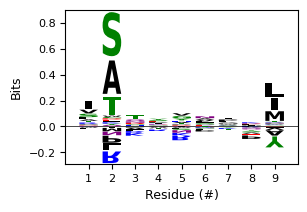

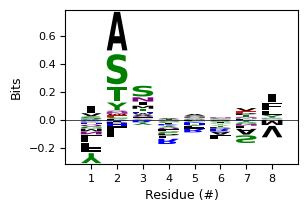

In [33]:
import logomaker
import warnings
warnings.filterwarnings('ignore')
#peptide_tableA = peptide_table[((peptide_table.Mean - peptide_table.Std) > 0.25) & 
#                              (peptide_table.Length == 9)]
#peptide_tableB = peptide_table[((peptide_table.Mean - peptide_table.Std) < -0.25) & 
#                              (peptide_table.Length == 9)]
peptide_tableA = peptide_table[(peptide_table.Length == 9)].sort_values('Mean', ascending=False).iloc[:round(len(peptide_table)/100)]
peptide_tableB = peptide_table[(peptide_table.Length == 9)].sort_values('Mean', ascending=True).iloc[:round(len(peptide_table)/100)]
pepA = list(peptide_tableA.Sequence.values)
pepB = list(peptide_tableB.Sequence.values)
ww_dfA = logomaker.alignment_to_matrix(pepA, to_type='information')
ww_dfB = logomaker.alignment_to_matrix(pepB, to_type='information')
ww_df = ww_dfA - ww_dfB
ww_df = ww_df.replace(np.nan, 0.)
ww_logo = logomaker.Logo(ww_df, 
                         #font_name='Stencil Std',
                         color_scheme='chemistry',
                         vpad=.1,
                         width=.8,
                         edgecolor='k',
                         figsize=(3, 2))
ww_logo.style_xticks(anchor=0, spacing=1, rotation=0)
#ww_logo.highlight_position(p=4, color='gold', alpha=.5)
ww_logo.ax.set_ylabel('Bits')
ww_logo.ax.set_xlim([-1, len(ww_df)])
ww_logo.ax.set_xticklabels([x+1 for x in range(9)])
ww_logo.ax.set_xlabel('Residue (#)')
plt.show()
plt.close()

peptide_tableA = peptide_table[(peptide_table.Length == 8)].sort_values('Mean', ascending=False).iloc[:round(len(peptide_table)/100)]
peptide_tableB = peptide_table[(peptide_table.Length == 8)].sort_values('Mean', ascending=True).iloc[:round(len(peptide_table)/100)]
pepA = list(peptide_tableA.Sequence.values)
pepB = list(peptide_tableB.Sequence.values)
ww_dfA = logomaker.alignment_to_matrix(pepA, to_type='information')
ww_dfB = logomaker.alignment_to_matrix(pepB, to_type='information')
ww_df = ww_dfA - ww_dfB
ww_df = ww_df.replace(np.nan, 0.)
ww_logo = logomaker.Logo(ww_df, 
                         #font_name='Stencil Std',
                         color_scheme='chemistry',
                         vpad=.1,
                         width=.8,
                         edgecolor='k',
                         figsize=(3, 2))
ww_logo.style_xticks(anchor=0, spacing=1, rotation=0)
#ww_logo.highlight_position(p=4, color='gold', alpha=.5)
ww_logo.ax.set_ylabel('Bits')
ww_logo.ax.set_xlim([-1, len(ww_df)])
ww_logo.ax.set_xticklabels([x+1 for x in range(8)])
ww_logo.ax.set_xlabel('Residue (#)')
plt.show()
plt.close()

In [34]:
upper = peptide_table.sort_values('Mean', ascending=False).iloc[:round(len(peptide_table)/20)].Mean.min()
lower = peptide_table.sort_values('Mean', ascending=True).iloc[:round(len(peptide_table)/20)].Mean.max()

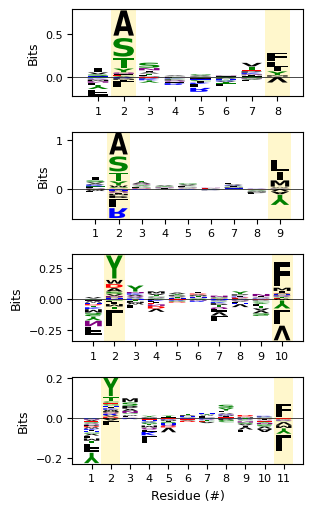

In [35]:
import logomaker
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(3.2, 5.2))
p2 = 7
for i, ax in zip([8, 9, 10, 11], [ax1, ax2, ax3, ax4]):
    peptide_tableA = peptide_table[(peptide_table.Length == i) & (peptide_table.Mean > upper)]
    peptide_tableB = peptide_table[(peptide_table.Length == i) & (peptide_table.Mean < lower)]
    pepA = list(peptide_tableA.Sequence.values)
    pepB = list(peptide_tableB.Sequence.values)
    ww_dfA = logomaker.alignment_to_matrix(pepA, to_type='information')
    ww_dfB = logomaker.alignment_to_matrix(pepB, to_type='information')
    ww_df = ww_dfA - ww_dfB
    ww_df = ww_df.replace(np.nan, 0.)
    ww_logo = logomaker.Logo(ww_df,
                             #font_name='Stencil Std',
                             color_scheme='chemistry',
                             vpad=.1,
                             width=.8,
                             edgecolor='k',
                             ax=ax)
#                             figsize=(4.5, 1.5))
    ww_logo.style_xticks(anchor=0, spacing=1, rotation=0)
    ww_logo.highlight_position(p=1, color='gold', alpha=.2)
    ww_logo.highlight_position(p=p2, color='gold', alpha=.2)
    p2+=1
    ww_logo.ax.set_ylabel('Bits')
    ww_logo.ax.set_xlim([-1, len(ww_df)])
    ww_logo.ax.set_xticklabels([x+1 for x in range(i)])
    if ax == ax4:
        ww_logo.ax.set_xlabel('Residue (#)')
    #ax.set_ylim([0, 1.4])
plt.tight_layout()
plt.savefig(join('images', 'Figure3C.svg'))
plt.show()
plt.close()

findfont: Font family 'Stencil Std' not found.
findfont: Font family 'Stencil Std' not found.
findfont: Font family 'Stencil Std' not found.
findfont: Font family 'Stencil Std' not found.
findfont: Font family 'Stencil Std' not found.
findfont: Font family 'Stencil Std' not found.
findfont: Font family 'Stencil Std' not found.
findfont: Font family 'Stencil Std' not found.
findfont: Font family 'Stencil Std' not found.
findfont: Font family 'Stencil Std' not found.
findfont: Font family 'Stencil Std' not found.
findfont: Font family 'Stencil Std' not found.
findfont: Font family 'Stencil Std' not found.
findfont: Font family 'Stencil Std' not found.
findfont: Font family 'Stencil Std' not found.
findfont: Font family 'Stencil Std' not found.
findfont: Font family 'Stencil Std' not found.
findfont: Font family 'Stencil Std' not found.
findfont: Font family 'Stencil Std' not found.
findfont: Font family 'Stencil Std' not found.
findfont: Font family 'Stencil Std' not found.
findfont: Fon

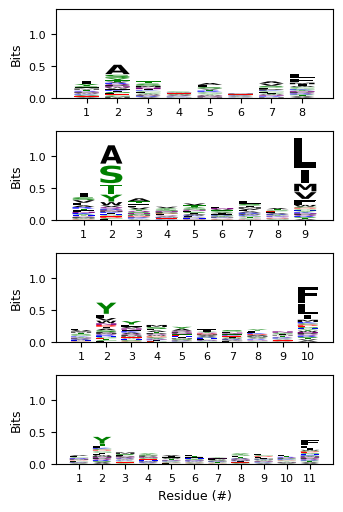

In [36]:
import logomaker
peptide_table2 = peptide_table[(peptide_table.Mean - peptide_table.Std) > 0.25]
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(3.5, 5.2))
for i, ax in zip([8, 9, 10, 11], [ax1, ax2, ax3, ax4]):
    pep = list(peptide_table2[peptide_table2.Length == i].Sequence.values)
    ww_df = logomaker.alignment_to_matrix(pep, to_type='information')
    ww_logo = logomaker.Logo(ww_df,
                             font_name='Stencil Std',
                             color_scheme='chemistry',
                             vpad=.1,
                             width=.8,
                             edgecolor='k',
                             ax=ax)
#                             figsize=(4.5, 1.5))
    ww_logo.style_xticks(anchor=0, spacing=1, rotation=0)
    #ww_logo.highlight_position(p=4, color='gold', alpha=.5)
    ww_logo.ax.set_ylabel('Bits')
    ww_logo.ax.set_xlim([-1, len(ww_df)])
    ww_logo.ax.set_xticklabels([x+1 for x in range(i)])
    if ax == ax4:
        ww_logo.ax.set_xlabel('Residue (#)')
    ax.set_ylim([0, 1.4])
plt.tight_layout()
plt.savefig(join('images', 'Figure3C.svg'))
plt.show()
plt.close()

In [37]:
mutant_dict = nestedDict()
files = [f for f in listdir('output/netMHCpan/pkl')] 
for tq, f in zip(tqdm(range(len(files))), files):
    if '_BA.pkl' in f:
        pkl = pd.read_pickle(join('output/netMHCpan/pkl', f)).reset_index()
        if len(pkl) > 0:
            pkl = pkl[pkl.residues.isin(list(pkl[pkl.mutation != 'WT'].residues))]
            for r in pkl.residues.unique():
                tmp = pkl[pkl.residues == r]
                protein = f.split('_')[0]
                wt_peptide = tmp[tmp.mutation == 'WT'].peptide
                mut_peptide = tmp[tmp.mutation != 'WT'].peptide
                mutant_dict[wt_peptide.values[0]]['Protein'] = protein
                mutant_dict[wt_peptide.values[0]]['Sequence'] = mut_peptide.values[0]
                mutant_dict[wt_peptide.values[0]]['Residues'] = r
                mutant_dict[wt_peptide.values[0]]['Mutation'] = tmp[tmp.mutation != 'WT'].mutation.values[0]

  0%|          | 0/270 [00:00<?, ?it/s]

In [38]:
len(pd.Series([mutant_dict[x]['Protein'] + '_' + mutant_dict[x]['Mutation'] for x in mutant_dict]).unique())

62

In [39]:
query = peptide_table.Sequence
for pep in query:
    if pep in list(mutant_dict):
        print(pep)

SSGVVNPVM
LTYTGAIKL
RSIFSRTL
TTNIVTRCL
QSASKIITL
HTQVVDMSM
AAVGELLLL
NYTVSCLPF
TYACWHHSIGF
LATHGLAAV
TTAAKLMVV
QSTQLGIEF
FSTASDTY
AAKAYKDYL
PYNSVTSSI
TTKGGRFVL
FASTEKSNI
VVNPVMEPI
FTVLCLTPVY
KVVSTTTNI
LFSTVFPPTSF
YCKSHKPPISF
VYFASTEKSNI
TAAKLMVVI
STVFPPTSF
TAAKLMVV
KLAKKFDTF
KSHKPPISF
SFNYLKSPNF
ASTEKSNII
AYYNTTKGGRF
RANNTKGSL
FSTVFPPTSF
LTPTWRVY
YYNTTKGGRF
RTIKGTHHW
LYENAFLPF
TFNGECPNF
AVFQSASKI
TFNGECPNFVF
YSGQSTQL
VFQSASKII
YTVSCLPFTI
FVSEETGTL
WSYSGQSTQL
EAAVKPLLV
TVFPPTSFGPL
LAKKFDTF
TVFPPTSF
SLPINVIVF
VFPPTSFGPL
GSSGVVNPV
FTVLCLTPV
HTIDGSSGVV
YSFVSEETGTL
YTVSCLPF
STQLGIEF
FVSEETGTLI
SSRGTSPARM
MSFTVLCL
SEKSYELQTPF
STQLGIEFL
MAAYVDNSSL
LTTAAKLMV
TVSCLPFTI
TYEGNSPFHPL
TVKNGSIHL
FFLYENAFLPF
SSPDAVTAY
NSVTSSIVI
GFDYVYNPF
VSEETGTLI
IPYNSVTSSI
VSSPDAVTAY
EGNSPFHPL
GSSGVVNPVM
YTEKWESGV
FQSASKIITL
KAFQLTPIA
VFQSASKIITL
VVSTTTNIV
YACWHHSIGF
LTENKYSQL
VAFNVVNKGHF
AFAVDAAKAY
KGTHHWLLL
GSLPINVIV
RSEKSYEL
YTERSEKSY
KAFQLTPIAV
SVNPYVCNA
KAFQLTPI
VFPPTSFGPLV
HADQLTPTW
VLSEARQHL
FFLYENAFL
FFLYEN

In [40]:
lineage_info = pd.read_excel('../../20210919_affinity_predictions2/COVID_HLA_typing_No_MRN_6-7-2021.xlsx')

In [41]:
lineage_info.head()

,Unnamed: 0,SAMPLE ID,strain,gisaid_epi_isl,sample_ID,Unnamed: 5,GISAID Clade,PANGO Lineage,Unnamed: 8,CBR_Q_ID,...,DRw-1,DRw-2,DQB-1,DQB-2,DQA-1,DQA-2,DP-1,DP-2,DPA-1,DPA-2
0,39,S-2006-000851,USA/MI-UM-2006S000851/2020,EPI_ISL_484710,S-2006-000851,COVRes-00101,S,A,NaN,NaN,...,DRB4*01:03,DRB4*01:03:01:02N,DQB1*03:01,DQB1*03:03,DQA1*02:01,DQA1*03:03,DPB1*04:01,DPB1*04:01,DPA1*01:03,DPA1*01:03
1,40,S-2006-000852,USA/MI-UM-2006S000852/2020,EPI_ISL_484711,S-2006-000852,COVRes-00102,GH,B.1,NaN,NaN,...,DRB5*02:02,NaN,DQB1*03:02,DQB1*05:02,DQA1*01:02,DQA1*03:01,DPB1*416:01 (02:01P),DPB1*665:01 (04:02P),DPA1*01:03,DPA1*01:03
2,41,S-2006-000856,USA/MI-UM-2006S000856/2020,EPI_ISL_484713,S-2006-000856,COVRes-00106,GH,B.1,NaN,NaN,...,DRB3*02:02,DRB4*01:03,DQB1*03:01,DQB1*03:01,DQA1*03:03,DQA1*05:05,DPB1*04:01,DPB1*04:01,DPA1*01:03,DPA1*01:03
3,142,S-2008-008473,USA/MI-UM-2006S000863/2020,EPI_ISL_484718,S-2006-000863,COVPro-00084,GH,B.1,NaN,COVPro-00084,...,DRB3*01:62 (01:01P),NaN,DQB1*04:02,DQB1*04:02,DQA1*04:01,DQA1*04:01,DPB1*01:01,DPB1*01:01,DPA1*02:02,DPA1*02:02
4,42,S-2006-000864,USA/MI-UM-2006S000864/2020,EPI_ISL_484719,S-2006-000864,COVRes-00122,GH,B.1,NaN,NaN,...,DRB3*02:02,DRB3*03:01,DQB1*03:01,DQB1*06:04,DQA1*01:02,DQA1*05:05,DPB1*04:01,DPB1*104:01,DPA1*01:03,DPA1*01:03


In [42]:
prob, mut, peptide, mutant = [], [], [], []
for tq, s in zip(tqdm(range(len(peptide_table))), peptide_table.Sequence):
    if s in mutant_dict:
        m = mutant_dict[s]['Sequence']
        prot = mutant_dict[s]['Protein']
        mr = mutant_dict[s]['Mutation']
        mp = df[(df.Peptide == m) & (df.HLA_type.str.contains('C'))].Probability.values
        wp = df[(df.Peptide == s) & (df.HLA_type.str.contains('C'))].Probability.values
        combined = ''
        for k, l in zip(s, m):
            if k == l:
                combined+=k
            else:
                combined+='['+k+'/'+l+']'
        for w in wp:
            prob.append(w)
            mut.append('WT')
            peptide.append(s)
            mutant.append(prot + ' ' + mr + '\n' + combined)
        for m in mp:
            prob.append(m)
            mut.append('MUT')
            peptide.append(s)
            mutant.append(prot + ' ' + mr + '\n' + combined)

  0%|          | 0/3871 [00:00<?, ?it/s]

In [43]:
plot_df = pd.DataFrame(data={'Probability' : prob, 'Strain' : mut, 'Peptide' : mutant})

In [44]:
from scipy.stats import ks_2samp

pvalues = []
for tq, p in zip(tqdm(range(len(plot_df))), plot_df.Peptide): #.unique():
    WT = plot_df[(plot_df.Peptide == p) & (plot_df.Strain == 'WT')].Probability.values
    MUT = plot_df[(plot_df.Peptide == p) & (plot_df.Strain == 'MUT')].Probability.values
    stat, pval = ks_2samp(WT, MUT)
    pvalues.append(pval)
    #if pval <= 0.05:
    #    print(p, pval)
plot_df['p'] = pvalues

  0%|          | 0/8360 [00:00<?, ?it/s]

In [45]:
length = []
for pept in plot_df.Peptide:
    length.append(len(pept.split('\n')[1].replace('[', '').replace('/', '').replace(']', '')) - 1)
plot_df['N'] = length

In [46]:
from statsmodels.stats.multitest import multipletests

p_corr = multipletests(plot_df[['Peptide', 'p']].drop_duplicates().p.values, method='fdr_twostage')[1]
replace_dict = {}
for ix, row in enumerate(plot_df[['Peptide', 'p']].drop_duplicates().iterrows()):
    replace_dict[row[1].Peptide] = p_corr[ix]

In [47]:
replace_p = []
for tq, row in zip(tqdm(range(len(plot_df))), plot_df.iterrows()):
    replace_p.append(replace_dict[row[1].Peptide])

  0%|          | 0/8360 [00:00<?, ?it/s]

In [48]:
plot_df['pc'] = replace_p

In [49]:
[x.replace('\n', ' ') for x in plot_df[plot_df.pc <= 0.05].Peptide.unique()]

['NSP3 S1717L G[S/L]LPINVIV',
 'NSP13 A52V SVNPYVCN[A/V]',
 'NS3 V256A TIDGSSGV[V/A]',
 'N P46S L[P/S]NNTASWF',
 'Spike D614G YQ[D/G]VNCTEV']

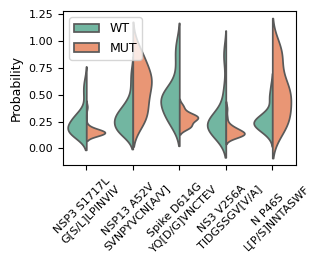

In [50]:
order_dict = {'NSP1 E41K\nVLS[E/K]ARQHL' : 0,
    'NSP1 D75E\nYVFIKRS[D/E]A' : 1,
    'NSP2 S65F\nYTER[S/F]EKSYEL' : 2,
    'NSP3 S702F\n[S/F]TQLGIEFL' : 3,
    'NSP3 S702F\nQ[S/F]TQLGIEF' : 4,
    'NSP3 S702F\nYSGQ[S/F]TQL' : 5,
    'NSP3 S1717L\nG[S/L]LPINVIV' : 6, 
    'NSP3 S1717L\nG[S/L]LPINVIVF' : 7,
    'NSP4 T327I\nLFLMSF[T/I]VL' : 8,
    'NSP6 L37F\n[L/F]YENAFLPF' : 9, 
    'NSP6 L37F\nFF[L/F]YENAF' : 10,
    'NSP6 L37F\nFF[L/F]YENAFL' : 11,
    'NSP13 A52V\nSVNPYVCN[A/V]' : 12,
    'Spike D614G\nYQ[D/G]VNCTEV' : 13,
    'Spike A684V\nR[A/V]RSVASQSI' : 14,
    'NS3 Q57H\n[Q/H]SASKIITL' : 15, 
    'NS3 V256A\nTIDGSSGV[V/A]' : 16,
    'NS3 V256A\nHTIDGSSGV[V/A]' : 17, 
    'NS7a Q94K\nV[Q/K]ELYSPIF' : 18,
    'NS7b S31L\nIFWF[S/L]LEL' : 19, 
    'NS9b T72I\nAFQL[T/I]PIAV' : 20,
    'NS9b T72I\nL[T/I]PIAVQM' : 21,
    'NS9c V27F\nAA[V/F]KPLLV' : 22,
    'N P46S\nL[P/S]NNTASWF' : 23,
    'N R68G\nFP[R/G]GQGVPI' : 24 }

plot_df2 = plot_df[(plot_df.pc <= 0.05)]
plot_df2 = plot_df2.sort_values('Strain', ascending=False).sort_values(by=['Peptide', 'Strain'], key=lambda x: x.map(order_dict), ascending=True)
#plot_df2.Peptide = [x.split('\n')[0] for x in plot_df2.Peptide]
fig, ax = plt.subplots(figsize=(3., 2))
sns.violinplot(data=plot_df2, y='Probability', x='Peptide', hue='Strain', split=True, inner=None, palette='Set2', ax=ax, scale='width')
#ax.scatter([1], [1.1], marker='*', c='k')
plt.xlabel('')
plt.xticks(rotation=45)
plt.legend(loc='upper left')
plt.savefig('images/Figure3D.svg')
plt.show()
plt.close()

In [51]:
data

,SAMPLE_ID,gisaid_epi_isl,PANGO Lineage,A-1,A-2,B-1,B-2,C-1,C-2,DR-1,...,DPA-1,DPA-2,COVID_TEST_POSITIVE_DATE,SEX,BIRTH_DATE,AGE,HEIGHT_IN_CM,WEIGHT_KG,BMI,HIGHEST_SOFA_10DAY
0,S-2006-000851,EPI_ISL_484710,A,A*02:01,A*23:01,B*18:01,B*50:02,C*04:01,C*07:01,DRB1*04:01,...,DPA1*01:03,DPA1*01:03,3/31/2020,Female,2/9/1934,86,165.00000,56.499405,16.19,7
1,S-2006-000852,EPI_ISL_484711,B.1,A*02:01,A*68:01,B*35:03,B*39:01,C*04:01,C*12:03,DRB1*08:01,...,DPA1*01:03,DPA1*01:03,3/30/2020,Male,11/10/1954,65,180.29936,119.098770,36.64,11
2,S-2006-000856,EPI_ISL_484713,B.1,A*03:02,A*26:01,B*35:01,B*35:01,C*04:01,C*04:01,DRB1*04:07,...,DPA1*01:03,DPA1*01:03,3/31/2020,Male,12/8/1948,71,182.88000,80.599025,24.10,11
3,S-2008-008473,EPI_ISL_484718,B.1,A*01:01,A*24:02,B*45:01,B*45:01,C*16:01,C*16:01,DRB1*03:02,...,DPA1*02:02,DPA1*02:02,3/31/2020,Male,7/18/1963,56,154.94000,99.608777,41.49,15
4,S-2006-000864,EPI_ISL_484719,B.1,A*02:05,A*68:01,B*40:01,B*58:01,C*03:02,C*03:04,DRB1*11:01,...,DPA1*01:03,DPA1*01:03,3/29/2020,Male,1/29/1979,41,170.18000,78.998979,27.28,10
5,S-2008-008453,EPI_ISL_484721,B.1,A*02:01,A*31:01,B*08:01,B*40:01,C*03:04,C*07:01,DRB1*03:01,...,DPA1*01:03,DPA1*01:03,3/27/2020,Male,7/22/1958,61,177.80000,118.998696,37.64,6
6,S-2006-000870,EPI_ISL_484723,B.1,A*33:03,A*66:01,B*53:01,B*58:02,C*04:01,C*06:02,DRB1*07:01,...,DPA1*02:02,DPA1*03:05Q,3/31/2020,Male,8/22/1946,73,180.34000,108.698758,33.42,9
7,S-2008-008451,EPI_ISL_484729,B.1,A*01:01,A*02:01,B*44:03,B*57:01,C*06:02,C*16:01,DRB1*01:01,...,DPA1*01:03,DPA1*02:01,3/30/2020,Male,11/15/1971,48,177.80000,133.492090,42.23,0
8,S-2006-000889,EPI_ISL_484736,B.1,A*30:02,A*32:01,B*45:01,B*81:01,C*08:04,C*16:01,DRB1*07:01,...,DPA1*01:03,DPA1*02:01,3/27/2020,Male,6/9/1975,44,177.80000,75.599025,23.91,16
9,S-2006-000892,EPI_ISL_484739,B.1,A*02:01,A*23:01,B*52:01,B*57:03,C*02:10,C*16:01,DRB1*13:01,...,DPA1*02:01,DPA1*03:05Q,3/30/2020,Female,11/10/1963,56,180.34000,154.698361,47.57,14


In [52]:
samples = list(overlap_dict)
ab = np.array([[overlap_dict[s][x]['AB'] / overlap_dict[s][x]['AB_total'] for x in overlap_dict[s]] for s in samples])
a = np.array([[overlap_dict[s][x]['A'] / overlap_dict[s][x]['A_total'] for x in overlap_dict[s]] for s in samples])
b = np.array([[overlap_dict[s][x]['B'] / overlap_dict[s][x]['B_total'] for x in overlap_dict[s]] for s in samples])
sofa = [data[data.SAMPLE_ID == s].HIGHEST_SOFA_10DAY.values[0] for s in samples]

In [53]:
from lmfit import Model

def linear(x, m, b):
    return x*m + b

lmodel = Model(linear)

0.3330651569204525 0.3698084298549249
0.003636010269696901 0.00931299464214239
-0.033248999099039916 0.07636674445932701
0.5619559845419594 0.9351130691786348


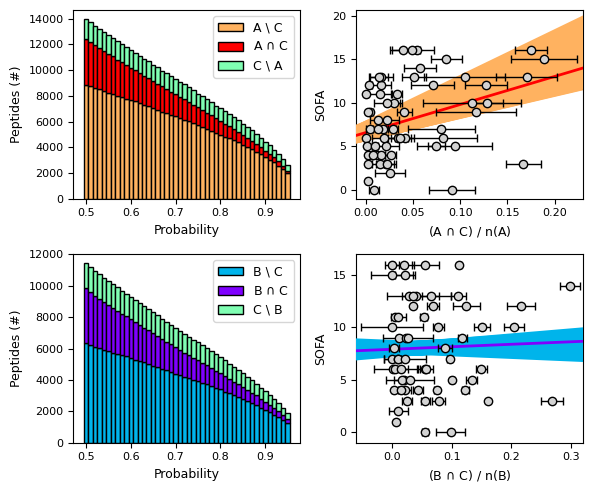

In [54]:
fig, ((ax1, ax3), (ax2, ax4)) = plt.subplots(2, 2, figsize=(6, 5))

probabilities = [round(p, 2) for p in probabilities]
x = probabilities #np.arange(0, len(probabilities), 1)
y0 = [len(venn_dict[p][0] - venn_dict[p][2]) for p in probabilities]
y1 = [len(venn_dict[p][0] & venn_dict[p][2]) for p in probabilities]
y2 = [len(venn_dict[p][2] - venn_dict[p][0]) for p in probabilities]

ax1.bar(x, y0, edgecolor='k', width=0.01, color=colors[-2], label='A \ C')
ax1.bar(x, y1, bottom=y0, edgecolor='k', width=0.01, color=colors[-1], label=r'A $\cap$ C')
ax1.bar(x, y2, bottom=np.array(y0)+np.array(y1), edgecolor='k', width=0.01, color=colors[-3], label='C \ A')
ax1.set_ylabel('Peptides (#)')
ax1.set_xlabel('Probability')
ax1.legend()

y0 = [len(venn_dict[p][1] - venn_dict[p][2]) for p in probabilities]
y1 = [len(venn_dict[p][1] & venn_dict[p][2]) for p in probabilities]
y2 = [len(venn_dict[p][2] - venn_dict[p][1]) for p in probabilities]

ax2.bar(x, y0, edgecolor='k', width=0.01, color=colors[1], label='B \ C')
ax2.bar(x, y1, bottom=y0, edgecolor='k', width=0.01, color=colors[0], label=r'B $\cap$ C')
ax2.bar(x, y2, bottom=np.array(y0)+np.array(y1), edgecolor='k', width=0.01, color=colors[2], label='C \ B')
ax2.set_xlabel('Probability')
ax2.set_ylabel('Peptides (#)')
ax2.legend()

#Ace = pd.read_csv('conditional_effects_Ao.csv')
#ax3.plot(Ace.effect1__, Ace.estimate__, color=colors[-1])
#ax3.fill_between(Ace.effect1__, Ace.lower__, Ace.upper__, alpha=1, color=colors[-2])
pcorr, pv = [], []
xvalues = np.arange(-0.05, 0.25, 0.01)
for ix, x in enumerate(a.T):
    result = lmodel.fit(sofa, x=x, m=1, b=0)
    ax3.plot(xvalues, [linear(i, result.best_values['m'], result.best_values['b']) for i in xvalues], color=colors[-2], alpha=1, lw=10, zorder=ix)
    pcorr.append(pearsonr(x, sofa)[0])
    pv.append(pearsonr(x, sofa)[1])
x = np.mean(a, axis=1)
result = lmodel.fit(sofa, x=x, m=1, b=0)
ax3.plot(xvalues, [linear(i, result.best_values['m'], result.best_values['b']) for i in xvalues], color=colors[-1], lw=2, zorder=len(a.T)+1, 
         label=r'$\rho$ = ' + str(round(np.mean(pcorr), 2)) + r' \$pm$ ' + str(round(np.std(pcorr), 2)))
ax3.errorbar(x, sofa, xerr=np.std(a, axis=1), fmt='o', c='lightgrey', lw=1, ecolor='k', capsize=3, 
             markeredgecolor='k', markersize=6, zorder=len(a.T)+2)
ax3.set_xlim([-.01, 0.23])
ax3.set_xlabel(r'(A $\cap$ C) / n(A)')
ax3.set_ylabel('SOFA')
print(min(pcorr), max(pcorr))
print(min(pv), max(pv))

#Bce = pd.read_csv('conditional_effects_Bo.csv')
#ax4.plot(Bce.effect1__, Bce.estimate__, color=colors[-1])
#ax4.fill_between(Bce.effect1__, Bce.lower__, Bce.upper__, alpha=1, color=colors[-2])
pcorr, pv = [], []
xvalues = np.arange(-0.1, 0.35, 0.01)
for ix, x in enumerate(b.T):
    result = lmodel.fit(sofa, x=x, m=1, b=0)
    ax4.plot(xvalues, [linear(i, result.best_values['m'], result.best_values['b']) for i in xvalues], color=colors[1], alpha=1, lw=10, zorder=ix)
    pcorr.append(pearsonr(x, sofa)[0])
    pv.append(pearsonr(x, sofa)[1])
x = np.mean(b, axis=1)
result = lmodel.fit(sofa, x=x, m=1, b=0)
ax4.plot(xvalues, [linear(i, result.best_values['m'], result.best_values['b']) for i in xvalues], color=colors[0], lw=2, zorder=len(a.T)+1, 
         label=r'$\rho$ = ' + str(round(np.mean(pcorr), 2)) + r' \$pm$ ' + str(round(np.std(pcorr), 2)))
ax4.errorbar(x, sofa, xerr=np.std(a, axis=1), fmt='o', c='lightgrey', lw=1, ecolor='k', capsize=3, 
             markeredgecolor='k', markersize=6, zorder=len(a.T)+2)
ax4.set_xlim([-.06, .32])
ax4.set_xlabel(r'(B $\cap$ C) / n(B)')
ax4.set_ylabel('SOFA')
ax4.set_ylim([-1, 17])
ax4.set_yticks([0, 5, 10, 15])
print(min(pcorr), max(pcorr))
print(min(pv), max(pv))

plt.tight_layout()
plt.savefig('images/Figure2.svg')
plt.show()
plt.close()

In [55]:
pd.DataFrame(data={'SOFA' : sofa, 'A_mean' : np.mean(a, axis=1), 'A_std' : np.std(a, axis=1)+1e-9,
                   'B_mean' : np.mean(b, axis=1), 'B_std' : np.std(b, axis=1)+1e-9}).to_csv('overlap_data.csv', index=False)

In [56]:
rho, p = [], []
for tq, i in zip(tqdm(range(10000)), range(10000)):
    m = np.random.randint(0, 100, 60)
    n = np.random.randint(0, 100, 60)
    pear = pearsonr(m, n)
    rho.append(pear[0])
    p.append(pear[1])

  0%|          | 0/10000 [00:00<?, ?it/s]

In [58]:
seq_dict_full = {
 'C*04:01': 'SHSMRYFSTSVSWPGRGEPRFIAVGYVDDTQFVRFDSDAASPRGEPREPWVEQEGPEYWDRETQKYKRQAQADRVNLRKLRGYYNQSEDGSHTLQRMFGCDLGPDGRLLRGYNQFAYDGKDYIALNEDLRSWTAADTAAQITQRKWEAAREAEQRRAYLEGTCVEWLRRYLENGKETLQR',
 'C*07:01': 'SHSMRYFDTAVSRPGRGEPRFISVGYVDDTQFVRFDSDAASPRGEPRAPWVEQEGPEYWDRETQNYKRQAQADRVSLRNLRGYYNQSEDGSHTLQRMYGCDLGPDGRLLRGYDQSAYDGKDYIALNEDLRSWTAADTAAQITQRKLEAARAAEQLRAYLEGTCVEWLRRYLENGKETLQR',
 'C*12:03': 'SHSMRYFYTAVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASPRGEPRAPWVEQEGPEYWDRETQKYKRQAQADRVSLRNLRGYYNQSEAGSHTLQWMYGCDLGPDGRLLRGYDQSAYDGKDYIALNEDLRSWTAADTAAQITQRKWEAAREAEQWRAYLEGTCVEWLRRYLENGKETLQR',
 'C*16:01': 'SHSMRYFYTAVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASPRGEPRAPWVEQEGPEYWDRETQKYKRQAQTDRVSLRNLRGYYNQSEAGSHTLQWMYGCDLGPDGRLLRGYDQSAYDGKDYIALNEDLRSWTAADTAAQITQRKWEAARAAEQQRAYLEGTCVEWLRRYLENGKETLQR',
 'C*03:02': 'SHSMRYFYTAVSRPGRGEPHFIAVGYVDDTQFVRFDSDAASPRGEPRAPWVEQEGPEYWDRETQKYKRQAQTDRVSLRNLRGYYNQSEAGSHILQRMYGCDVGPDGRLLRGYDQSAYDGKDYIALNEDLRSWTAADTAAQITQRKWEAAREAEQLRAYLEGLCVEWLRRYLKNGKETLQR',
 'C*03:04': 'SHSMRYFYTAVSRPGRGEPHFIAVGYVDDTQFVRFDSDAASPRGEPRAPWVEQEGPEYWDRETQKYKRQAQTDRVSLRNLRGYYNQSEAGSHIIQRMYGCDVGPDGRLLRGYDQYAYDGKDYIALNEDLRSWTAADTAAQITQRKWEAAREAEQLRAYLEGLCVEWLRRYLKNGKETLQR',
 'C*06:02': 'SHSMRYFDTAVSRPGRGEPRFISVGYVDDTQFVRFDSDAASPRGEPRAPWVEQEGPEYWDRETQKYKRQAQADRVNLRKLRGYYNQSEDGSHTLQWMYGCDLGPDGRLLRGYDQSAYDGKDYIALNEDLRSWTAADTAAQITQRKWEAAREAEQWRAYLEGTCVEWLRRYLENGKETLQR',
 'C*08:04': 'SHSMRYFYTAVSRPGRGEPRFIAVGYVDDTQFVQFDSDAASPRGEPRAPWVEQEGPEYWDRETQKYKRQAQTDRVSLRNLRGYYNQSEAGSHTLQRMYGCDLGPDGRLLRGYNQFAYDGKDYIALNEDLRSWTAADKAAQITQRKWEAAREAEQLRAYLEGTCVEWLRRYLENGKKTLQR',
 'C*02:10': 'SHSMRYFYTAVSRPSRGEPHFIAVGYVDDTQFVRFDSDAASPRGEPRAPWVEQEGPEYWDRETQKYKRQAQTDRVNLRKLRGYYNQSEAGSHTLQRMYGCDLGPDGRLLRGYDQSAYDGKDYIALNEDLRSWTAADTAAQITQRKWEAAREAEQWRAYLEGECVEWLRRYLENGKETLQR',
 'C*18:02': 'SHSMRYFDTAVSRPGRGEPRFISVGYVDDTQFVRFDSDAASPRGEPRAPWVEQEGPEYWDRETQKYKRQAQADRVNLRKLRGYYNQSEDGSHTLQRMFGCDLGPDGRLLRGYNQFAYDGKDYIALNEDLRSWTAADTAAQITQRKWEAAREAEQRRAYLEGTCVEWLRRYLENGKETLQR',
 'C*07:18': 'SHSMRYFDTAVSRPGRGEPRFISVGYVDDTQFVRFDSDAASPRGEPRAPWVEQEGPEYWDRETQNYKRQAQADRVSLRNLRGYYNQSEDGSHTLQRMYGCDLGPDGRLLRGYDQSAYDGKDYIALNEDLRSWTAADTAAQITQRKLEAARAAEQLRAYLEGTCVEWLRRYLENGKETLQR',
 'C*08:02': 'SHSMRYFYTAVSRPGRGEPRFIAVGYVDDTQFVQFDSDAASPRGEPRAPWVEQEGPEYWDRETQKYKRQAQTDRVSLRNLRGYYNQSEAGSHTLQRMYGCDLGPDGRLLRGYNQFAYDGKDYIALNEDLRSWTAADKAAQITQRKWEAAREAEQRRAYLEGTCVEWLRRYLENGKKTLQR',
 'C*07:02': 'SHSMRYFDTAVSRPGRGEPRFISVGYVDDTQFVRFDSDAASPRGEPRAPWVEQEGPEYWDRETQKYKRQAQADRVSLRNLRGYYNQSEDGSHTLQRMSGCDLGPDGRLLRGYDQSAYDGKDYIALNEDLRSWTAADTAAQITQRKLEAARAAEQLRAYLEGTCVEWLRRYLENGKETLQR',
 'C*02:02': 'SHSMRYFYTAVSRPSRGEPHFIAVGYVDDTQFVRFDSDAASPRGEPRAPWVEQEGPEYWDRETQKYKRQAQTDRVNLRKLRGYYNQSEAGSHTLQRMYGCDLGPDGRLLRGYDQSAYDGKDYIALNEDLRSWTAADTAAQITQRKWEAAREAEQWRAYLEGECVEWLRRYLENGKETLQR',
 'C*05:01': 'SHSMRYFYTAVSRPGRGEPRFIAVGYVDDTQFVQFDSDAASPRGEPRAPWVEQEGPEYWDRETQKYKRQAQTDRVNLRKLRGYYNQSEAGSHTLQRMYGCDLGPDGRLLRGYNQFAYDGKDYIALNEDLRSWTAADKAAQITQRKWEAAREAEQRRAYLEGTCVEWLRRYLENGKKTLQR',
 'C*17:01': 'SHSMRYFYTAVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASPRGEPRAPWVEQEGPEYWDRETQKYKRQAQADRVNLRKLRGYYNQSEAGSHTIQRMYGCDLGPDGRLLRGYNQFAYDGKDYIALNEDLRSWTAADTAAQISQRKLEAAREAEQLRAYLEGECVEWLRGYLENGKETLQR',
 'C*03:03': 'SHSMRYFYTAVSRPGRGEPHFIAVGYVDDTQFVRFDSDAASPRGEPRAPWVEQEGPEYWDRETQKYKRQAQTDRVSLRNLRGYYNQSEARSHIIQRMYGCDVGPDGRLLRGYDQYAYDGKDYIALNEDLRSWTAADTAAQITQRKWEAAREAEQLRAYLEGLCVEWLRRYLKNGKETLQR',
 'C*14:02': 'SHSMRYFSTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASPRGEPRAPWVEQEGPEYWDRETQKYKRQAQTDRVSLRNLRGYYNQSEAGSHTLQWMFGCDLGPDGRLLRGYDQSAYDGKDYIALNEDLRSWTAADTAAQITQRKWEAAREAEQRRAYLEGTCVEWLRRYLENGKETLQR',
 'C*18:01': 'SHSMRYFDTAVSRPGRGEPRFISVGYVDDTQFVRFDSDAASPRGEPRAPWVEQEGPEYWDRETQKYKRQAQADRVNLRKLRGYYNQSEDGSHTLQRMFGCDLGPDGRLLRGYNQFAYDGKDYIALNEDLRSWTAADTAAQITQRKWEAAREAEQRRAYLEGTCVEWLRRYLENGKETLQR',
 'C*01:02': 'SHSMKYFFTSVSRPGRGEPRFISVGYVDDTQFVRFDSDAASPRGEPRAPWVEQEGPEYWDRETQKYKRQAQTDRVSLRNLRGYYNQSEAGSHTLQWMCGCDLGPDGRLLRGYDQYAYDGKDYIALNEDLRSWTAADTAAQITQRKWEAAREAEQRRAYLEGTCVEWLRRYLENGKETLQR',
 'C*07:04': 'SHSMRYFDTAVSRPGRGEPRFISVGYVDDTQFVRFDSDAASPRGEPRAPWVEQEGPEYWDRETQKYKRQAQADRVSLRNLRGYYNQSEDGSHTFQRMYGCDLGPDGRLLRGYDQFAYDGKDYIALNEDLRSWTAADTAAQITQRKLEAARAAEQDRAYLEGTCVEWLRRYLENGKKTLQR',
 'C*07:06': 'SHSMRYFDTAVSRPGRGEPRFISVGYVDDTQFVRFDSDAASPRGEPRAPWVEQEGPEYWDRETQNYKRQAQADRVSLRNLRGYYNQSEDGSHTLQRMYGCDLGPDGRLLRGYDQSAYDGKDYIALNEDLRSWTAADTAAQITQRKLEAARAAEQLRAYLEGTCVEWLRRYLENGKETLQR'}

surface = [4,6,8,32,54,58,62,64,65,66,68,69,72,73,76,79,80,83,94,96,98,99,113,115,122,123,132,142,145,146,149,151,154,155,157,158,159,160,162,163,165,166,170]
surface = [x-1 for x in surface]

seq_dict = {}
for s in seq_dict_full:
    seq_dict[s] = [seq_dict_full[s][a] for a in surface]
    
allele_names = list(seq_dict)
sequences = []
for yi in allele_names:
    sequences.append(list(seq_dict[yi]))
    
corpus = pd.DataFrame(data={'id' : allele_names, 'sequence' : sequences})
sgt_ = SGT(kappa=1, lengthsensitive=False, mode='multiprocessing')
sgtembedding_df = sgt_.fit_transform(corpus)
sgtembedding_df = sgtembedding_df.set_index('id')

pca = PCA(n_components=2)
pca.fit(sgtembedding_df)
X=pca.transform(sgtembedding_df)
pca_df = pd.DataFrame(data=X, columns=['x1', 'x2'])
kmeans = KMeans(n_clusters=3, max_iter = 300, random_state=0)
kmeans.fit(pca_df)
labels = kmeans.predict(pca_df)
centroids = kmeans.cluster_centers_
kmDF = pd.DataFrame(data={'Allele' : allele_names, 'Label' : labels})
    
km_colors = plt.get_cmap('tab20').colors
km_colors1 = [km_colors[6], km_colors[0], km_colors[8]]
km_colors2 = [km_colors[7], km_colors[1], km_colors[9]]

c1 = [km_colors1[x] for x in kmeans.labels_]
c2 = [km_colors2[x] for x in kmeans.labels_]
fig, ax = plt.subplots(figsize=(3, 3))
ax.scatter(pca_df.x1, pca_df.x2, color=c2, edgecolor=c1, alpha=1.0, linewidth=1)
for x1, x2, an in zip(pca_df.x1, pca_df.x2, allele_names):
    plt.text(x1+.02, x2+.02, an)
plt.xlim([pca_df.x1.min(), pca_df.x1.max()])
plt.ylim([pca_df.x2.min(), pca_df.x2.max()])
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_ylim([-0.4, 0.55])
ax.set_xlim([-0.45, 0.9])
plt.tight_layout()
#plt.savefig(join('images', 'Figure5A.svg'))
plt.show()
plt.close()

INFO: Pandarallel will run on 11 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


In [ ]:
classif = {'01:02' : 1, '02:02' : 2, '02:10' : 2, '03:02' : 1, '03:03' : 1, '03:04' : 1, '14:02' : 1, '16:01' : 1,
            '04:01' : 2, '05:01' : 2, '08:02' : 1, '08:04' : 1, '17:01' : 2, '18:01' : 2, '18:02' : 2, '06:02' : 2,
            '07:01' : 1, '07:02' : 1, '07:04' : 1, '07:06' : 1, '07:18' : 1, '12:03' : 1}

samples = list(sample_dict)
probabilities = np.arange(0.5, 0.96, 0.01)
sns_samples, cluster, probability, sofa, n, c = [], [], [], [], [], []
for tq, s in zip(tqdm(range(len(samples))), samples):
    tmp = sample_dict[s]
    tmp = tmp[tmp.Allele.str.contains('C')]
    alleles = tmp.Allele.unique()
    if len(alleles) == 1:
        alleles = [alleles[0]]*2
    for a in alleles:
        for p in probabilities:
            n.append(len(tmp[(tmp.Allele == a) & (tmp.Probability >= p)]))
            sofa.append(data[data.SAMPLE_ID == s].HIGHEST_SOFA_10DAY.values[0])
            probability.append(p)
            cluster.append(kmDF[kmDF.Allele == a].Label.values[0])
            sns_samples.append(s)
            c.append(classif[a.replace('C*', '')])
sns_df = pd.DataFrame(data={'Samples' : sns_samples, 'Cluster' : cluster, 'SOFA' : sofa, 'Probability' : probability, 'N' : n, 'C' : c})

  0%|          | 0/60 [00:00<?, ?it/s]

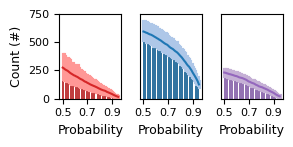

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(3, 1.5))
for i, ax in zip(range(3), [ax1, ax2, ax3]):
    tmp = sns_df[sns_df.Cluster == i]
    sns.barplot(data=tmp, x='Probability', y='N', color=km_colors1[i], ax=ax, errcolor=km_colors2[i])
    ax.plot(np.arange(0, len(probabilities), 1), [tmp[tmp.Probability == p].N.mean() for p in probabilities], color=km_colors1[i])
    ax.set_ylabel('')
    ax.set_ylim([0, 750])
    ax.set_xticks([0, 20, 40])
    ax.set_xticklabels([0.5, 0.7, 0.9])
ax2.set_yticks([])
ax3.set_yticks([])
ax1.set_ylabel('Count (#)')
plt.tight_layout()
plt.savefig('images/Figure5E.svg')
plt.show()
plt.close()

In [ ]:
from scipy.stats import f_oneway
f_oneway(sns_df[sns_df.Cluster == 2].groupby('Samples').mean().N, sns_df[sns_df.Cluster == 1].groupby('Samples').mean().N, 
         sns_df[sns_df.Cluster == 0].groupby('Samples').mean().N)

F_onewayResult(statistic=34.62808703687456, pvalue=6.5661576191154765e-12)

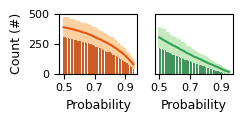

In [ ]:
c_colors = plt.get_cmap('tab20c').colors

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(2.5, 1.25))

tmp = sns_df[sns_df.C == 1]
sns.barplot(data=tmp, x='Probability', y='N', color=c_colors[4], ax=ax1, errcolor=c_colors[7])
ax1.plot(np.arange(0, len(probabilities), 1), [tmp[tmp.Probability == p].N.mean() for p in probabilities], color=c_colors[4])

tmp = sns_df[sns_df.C == 2]
sns.barplot(data=tmp, x='Probability', y='N', color=c_colors[8], ax=ax2, errcolor=c_colors[11])
ax2.plot(np.arange(0, len(probabilities), 1), [tmp[tmp.Probability == p].N.mean() for p in probabilities], color=c_colors[8])

ax1.set_ylabel('Count (#)')
ax2.set_ylabel('')
ax1.set_ylim([0, 500])
ax2.set_ylim([0, 500])
ax1.set_xticks([0, 20, 40])
ax2.set_xticks([0, 20, 40])
ax1.set_xticklabels([0.5, 0.7, 0.9])
ax2.set_xticklabels([0.5, 0.7, 0.9])
ax2.set_yticks([])
plt.tight_layout()
plt.savefig('images/Figure4B.svg')
plt.show()
plt.close()

In [ ]:
from scipy.stats import ttest_ind
ttest_ind(sns_df[sns_df.C == 1].groupby('Samples').mean().N, sns_df[sns_df.C == 2].groupby('Samples').mean().N)

Ttest_indResult(statistic=3.410255421291196, pvalue=0.0010196473231890654)

In [ ]:
samples = list(sample_dict)
sns_samples, cluster, sofa, n, c = [], [], [], [], []
for tq, s in zip(tqdm(range(len(samples))), samples):
    tmp = sample_dict[s]
    tmp = tmp[tmp.Allele.str.contains('C')]
    alleles = tmp.Allele.unique()
    if len(alleles) == 1:
        alleles = [alleles[0]]*2
    for a in alleles:
        n.append(len(tmp[(tmp.Allele == a) & (tmp.Probability >= p)]))
        sofa.append(data[data.SAMPLE_ID == s].HIGHEST_SOFA_10DAY.values[0])
        cluster.append(kmDF[kmDF.Allele == a].Label.values[0])
        sns_samples.append(s)
        c.append(classif[a.replace('C*', '')])
sns_df = pd.DataFrame(data={'Samples' : sns_samples, 'Cluster' : cluster, 'SOFA' : sofa, 'N' : n, 'C' : c})

  0%|          | 0/60 [00:00<?, ?it/s]

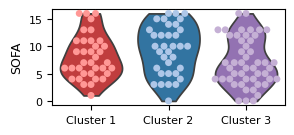

In [ ]:
fig, ax = plt.subplots(figsize=(3, 1.25))
sns.violinplot(data=sns_df, y='SOFA', x='Cluster', cut=0, palette=km_colors1, ax=ax, inner=None)
sns.swarmplot(data=sns_df, y='SOFA', x='Cluster', palette=km_colors2, ax=ax)
ax.set_xticklabels(['Cluster 1', 'Cluster 2', 'Cluster 3'])
ax.set_xlabel('')
plt.savefig('images/Figure5F.svg')
plt.show()
plt.close()

In [ ]:
a = sns_df[sns_df.Cluster == 0].SOFA.values
b = sns_df[sns_df.Cluster == 1].SOFA.values
c = sns_df[sns_df.Cluster == 2].SOFA.values
f_oneway(a, b, c)

F_onewayResult(statistic=2.978038377558975, pvalue=0.054764366165877335)

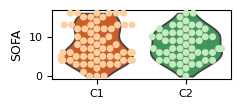

In [ ]:
fig, ax = plt.subplots(figsize=(2.3, 0.9))
sns.violinplot(data=sns_df, y='SOFA', x='C', cut=0, palette=[c_colors[4], c_colors[8]], ax=ax, inner=None)
sns.swarmplot(data=sns_df, y='SOFA', x='C', palette=[c_colors[7], c_colors[11]], ax=ax)
ax.set_xticklabels(['C1', 'C2'])
ax.set_xlabel('')
plt.savefig('images/Figure4C.svg')
plt.show()
plt.close()

In [ ]:
b = sns_df[sns_df.C == 1].SOFA.values
c = sns_df[sns_df.C == 2].SOFA.values
ttest_ind(b, c)

Ttest_indResult(statistic=0.025115668055365383, pvalue=0.9800051270885539)

In [ ]:
seq_dict_full = {
 'C*04:01': 'SHSMRYFSTSVSWPGRGEPRFIAVGYVDDTQFVRFDSDAASPRGEPREPWVEQEGPEYWDRETQKYKRQAQADRVNLRKLRGYYNQSEDGSHTLQRMFGCDLGPDGRLLRGYNQFAYDGKDYIALNEDLRSWTAADTAAQITQRKWEAAREAEQRRAYLEGTCVEWLRRYLENGKETLQR',
 'C*07:01': 'SHSMRYFDTAVSRPGRGEPRFISVGYVDDTQFVRFDSDAASPRGEPRAPWVEQEGPEYWDRETQNYKRQAQADRVSLRNLRGYYNQSEDGSHTLQRMYGCDLGPDGRLLRGYDQSAYDGKDYIALNEDLRSWTAADTAAQITQRKLEAARAAEQLRAYLEGTCVEWLRRYLENGKETLQR',
 'C*12:03': 'SHSMRYFYTAVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASPRGEPRAPWVEQEGPEYWDRETQKYKRQAQADRVSLRNLRGYYNQSEAGSHTLQWMYGCDLGPDGRLLRGYDQSAYDGKDYIALNEDLRSWTAADTAAQITQRKWEAAREAEQWRAYLEGTCVEWLRRYLENGKETLQR',
 'C*16:01': 'SHSMRYFYTAVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASPRGEPRAPWVEQEGPEYWDRETQKYKRQAQTDRVSLRNLRGYYNQSEAGSHTLQWMYGCDLGPDGRLLRGYDQSAYDGKDYIALNEDLRSWTAADTAAQITQRKWEAARAAEQQRAYLEGTCVEWLRRYLENGKETLQR',
 'C*03:02': 'SHSMRYFYTAVSRPGRGEPHFIAVGYVDDTQFVRFDSDAASPRGEPRAPWVEQEGPEYWDRETQKYKRQAQTDRVSLRNLRGYYNQSEAGSHILQRMYGCDVGPDGRLLRGYDQSAYDGKDYIALNEDLRSWTAADTAAQITQRKWEAAREAEQLRAYLEGLCVEWLRRYLKNGKETLQR',
 'C*03:04': 'SHSMRYFYTAVSRPGRGEPHFIAVGYVDDTQFVRFDSDAASPRGEPRAPWVEQEGPEYWDRETQKYKRQAQTDRVSLRNLRGYYNQSEAGSHIIQRMYGCDVGPDGRLLRGYDQYAYDGKDYIALNEDLRSWTAADTAAQITQRKWEAAREAEQLRAYLEGLCVEWLRRYLKNGKETLQR',
 'C*06:02': 'SHSMRYFDTAVSRPGRGEPRFISVGYVDDTQFVRFDSDAASPRGEPRAPWVEQEGPEYWDRETQKYKRQAQADRVNLRKLRGYYNQSEDGSHTLQWMYGCDLGPDGRLLRGYDQSAYDGKDYIALNEDLRSWTAADTAAQITQRKWEAAREAEQWRAYLEGTCVEWLRRYLENGKETLQR',
 'C*08:04': 'SHSMRYFYTAVSRPGRGEPRFIAVGYVDDTQFVQFDSDAASPRGEPRAPWVEQEGPEYWDRETQKYKRQAQTDRVSLRNLRGYYNQSEAGSHTLQRMYGCDLGPDGRLLRGYNQFAYDGKDYIALNEDLRSWTAADKAAQITQRKWEAAREAEQLRAYLEGTCVEWLRRYLENGKKTLQR',
 'C*02:10': 'SHSMRYFYTAVSRPSRGEPHFIAVGYVDDTQFVRFDSDAASPRGEPRAPWVEQEGPEYWDRETQKYKRQAQTDRVNLRKLRGYYNQSEAGSHTLQRMYGCDLGPDGRLLRGYDQSAYDGKDYIALNEDLRSWTAADTAAQITQRKWEAAREAEQWRAYLEGECVEWLRRYLENGKETLQR',
 'C*18:02': 'SHSMRYFDTAVSRPGRGEPRFISVGYVDDTQFVRFDSDAASPRGEPRAPWVEQEGPEYWDRETQKYKRQAQADRVNLRKLRGYYNQSEDGSHTLQRMFGCDLGPDGRLLRGYNQFAYDGKDYIALNEDLRSWTAADTAAQITQRKWEAAREAEQRRAYLEGTCVEWLRRYLENGKETLQR',
 'C*07:18': 'SHSMRYFDTAVSRPGRGEPRFISVGYVDDTQFVRFDSDAASPRGEPRAPWVEQEGPEYWDRETQNYKRQAQADRVSLRNLRGYYNQSEDGSHTLQRMYGCDLGPDGRLLRGYDQSAYDGKDYIALNEDLRSWTAADTAAQITQRKLEAARAAEQLRAYLEGTCVEWLRRYLENGKETLQR',
 'C*08:02': 'SHSMRYFYTAVSRPGRGEPRFIAVGYVDDTQFVQFDSDAASPRGEPRAPWVEQEGPEYWDRETQKYKRQAQTDRVSLRNLRGYYNQSEAGSHTLQRMYGCDLGPDGRLLRGYNQFAYDGKDYIALNEDLRSWTAADKAAQITQRKWEAAREAEQRRAYLEGTCVEWLRRYLENGKKTLQR',
 'C*07:02': 'SHSMRYFDTAVSRPGRGEPRFISVGYVDDTQFVRFDSDAASPRGEPRAPWVEQEGPEYWDRETQKYKRQAQADRVSLRNLRGYYNQSEDGSHTLQRMSGCDLGPDGRLLRGYDQSAYDGKDYIALNEDLRSWTAADTAAQITQRKLEAARAAEQLRAYLEGTCVEWLRRYLENGKETLQR',
 'C*02:02': 'SHSMRYFYTAVSRPSRGEPHFIAVGYVDDTQFVRFDSDAASPRGEPRAPWVEQEGPEYWDRETQKYKRQAQTDRVNLRKLRGYYNQSEAGSHTLQRMYGCDLGPDGRLLRGYDQSAYDGKDYIALNEDLRSWTAADTAAQITQRKWEAAREAEQWRAYLEGECVEWLRRYLENGKETLQR',
 'C*05:01': 'SHSMRYFYTAVSRPGRGEPRFIAVGYVDDTQFVQFDSDAASPRGEPRAPWVEQEGPEYWDRETQKYKRQAQTDRVNLRKLRGYYNQSEAGSHTLQRMYGCDLGPDGRLLRGYNQFAYDGKDYIALNEDLRSWTAADKAAQITQRKWEAAREAEQRRAYLEGTCVEWLRRYLENGKKTLQR',
 'C*17:01': 'SHSMRYFYTAVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASPRGEPRAPWVEQEGPEYWDRETQKYKRQAQADRVNLRKLRGYYNQSEAGSHTIQRMYGCDLGPDGRLLRGYNQFAYDGKDYIALNEDLRSWTAADTAAQISQRKLEAAREAEQLRAYLEGECVEWLRGYLENGKETLQR',
 'C*03:03': 'SHSMRYFYTAVSRPGRGEPHFIAVGYVDDTQFVRFDSDAASPRGEPRAPWVEQEGPEYWDRETQKYKRQAQTDRVSLRNLRGYYNQSEARSHIIQRMYGCDVGPDGRLLRGYDQYAYDGKDYIALNEDLRSWTAADTAAQITQRKWEAAREAEQLRAYLEGLCVEWLRRYLKNGKETLQR',
 'C*14:02': 'SHSMRYFSTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASPRGEPRAPWVEQEGPEYWDRETQKYKRQAQTDRVSLRNLRGYYNQSEAGSHTLQWMFGCDLGPDGRLLRGYDQSAYDGKDYIALNEDLRSWTAADTAAQITQRKWEAAREAEQRRAYLEGTCVEWLRRYLENGKETLQR',
 'C*18:01': 'SHSMRYFDTAVSRPGRGEPRFISVGYVDDTQFVRFDSDAASPRGEPRAPWVEQEGPEYWDRETQKYKRQAQADRVNLRKLRGYYNQSEDGSHTLQRMFGCDLGPDGRLLRGYNQFAYDGKDYIALNEDLRSWTAADTAAQITQRKWEAAREAEQRRAYLEGTCVEWLRRYLENGKETLQR',
 'C*01:02': 'SHSMKYFFTSVSRPGRGEPRFISVGYVDDTQFVRFDSDAASPRGEPRAPWVEQEGPEYWDRETQKYKRQAQTDRVSLRNLRGYYNQSEAGSHTLQWMCGCDLGPDGRLLRGYDQYAYDGKDYIALNEDLRSWTAADTAAQITQRKWEAAREAEQRRAYLEGTCVEWLRRYLENGKETLQR',
 'C*07:04': 'SHSMRYFDTAVSRPGRGEPRFISVGYVDDTQFVRFDSDAASPRGEPRAPWVEQEGPEYWDRETQKYKRQAQADRVSLRNLRGYYNQSEDGSHTFQRMYGCDLGPDGRLLRGYDQFAYDGKDYIALNEDLRSWTAADTAAQITQRKLEAARAAEQDRAYLEGTCVEWLRRYLENGKKTLQR',
 'C*07:06': 'SHSMRYFDTAVSRPGRGEPRFISVGYVDDTQFVRFDSDAASPRGEPRAPWVEQEGPEYWDRETQNYKRQAQADRVSLRNLRGYYNQSEDGSHTLQRMYGCDLGPDGRLLRGYDQSAYDGKDYIALNEDLRSWTAADTAAQITQRKLEAARAAEQLRAYLEGTCVEWLRRYLENGKETLQR'}
start = 26
arr1 = [4,6,8,32,54,58,62,64,65,66,68,69,72,73,76,79,80,83,94,96,98,99,113,115,122,123,132,142,145,146,149,151,154,155,157,158,159,160,162,163,165,166,170]
arr1 = [x-1 for x in arr1]
arr2 = list(np.arange(1, 9, 1)) + [31, 32, 33] + list(np.arange(53, 100, 1)) + list(np.arange(112, 123)) + list(np.arange(131, 171))

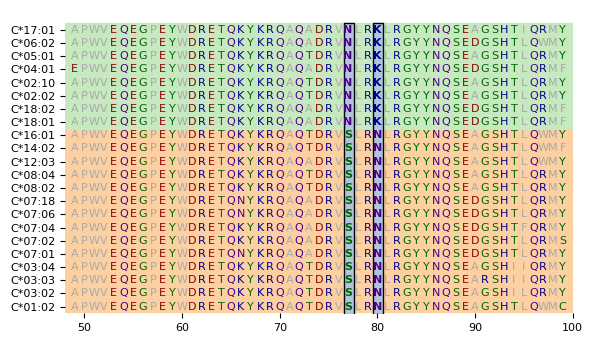

In [ ]:
arr1 = arr2
alleles = ['C*01:02', 'C*03:02', 'C*03:03', 'C*03:04', 'C*07:01', 'C*07:02',
             'C*07:04', 'C*07:06', 'C*07:18', 'C*08:02', 'C*08:04', 'C*12:03', 'C*14:02', 'C*16:01',
             'C*18:01', 'C*18:02', 'C*02:02', 'C*02:10', 'C*04:01', 'C*05:01', 'C*06:02', 'C*17:01']

color_dict = {'darkgrey' : ['A', 'F', 'I', 'L', 'M', 'P', 'V', 'W'],
              'darkgreen' : ['C', 'G', 'S', 'T', 'Y'], 'darkred' : ['D', 'E'], 'darkblue' : ['H', 'K', 'R'],
              'indigo' : ['N', 'Q']}
fig, ax = plt.subplots(figsize=(6., 3.5))
fs=8
resi = np.arange(47, 98, 1)
for ix, s in enumerate(alleles):
    for jx, aa in enumerate(seq_dict_full[s]):
        color = 'black'
        if jx in list(resi):
            fw = 'ultralight'
            for c in color_dict:
                if aa in color_dict[c]:
                    color = c
            if jx in [75, 78]:
                fw = 'heavy'
            ax.text(jx+2, ix, aa, color=color, fontsize=fs, horizontalalignment='center', 
                    verticalalignment='center', fontweight=fw)

ax.fill_between(np.arange(0, 1000, 10), [-1]*100, [13.5]*100, color=c_colors[7])
ax.fill_between(np.arange(0, 1000, 10), [13.5]*100, [21.5]*100, color=c_colors[11])
ax.fill_between([79.55, 80.6], [-1]*2, [21.5]*2, color='lightsteelblue', edgecolor='k')
ax.fill_between([76.55, 77.6], [-1]*2, [21.5]*2, color='lightsteelblue', edgecolor='k')
ax.set_xlim([resi[0] + 1, resi[-1] + 3])
ax.set_ylim([-.5, len(alleles)+.5])
ax.set_yticks(range(0, len(alleles)))
ax.set_yticklabels(alleles)
for key, spine in ax.spines.items():
    spine.set_visible(False)
plt.tight_layout()
plt.savefig('images/Figure4A.svg')
plt.show()
plt.close()

In [ ]:
sofa, C1, C2, cl0, cl1, cl2 = [], [], [], [], [], [] 
for s in sns_df.Samples.unique():
    tmp = sns_df[sns_df.Samples == s]
    c = list(tmp.C.values)
    cl = list(tmp.Cluster.values)
    sofa.append(tmp.SOFA.values[0])
    C1.append(c.count(1))
    C2.append(c.count(2))
    cl0.append(cl.count(0))
    cl1.append(cl.count(1))
    cl2.append(cl.count(2))
geno_df = pd.DataFrame(data={'SOFA' : sofa, 'C1' : C1, 'C2' : C2, 'CL1' : cl0, 'CL2' : cl1, 'CL3' : cl2})

In [ ]:
tabc = plt.get_cmap('tab20c').colors
tabb = plt.get_cmap('tab20b').colors

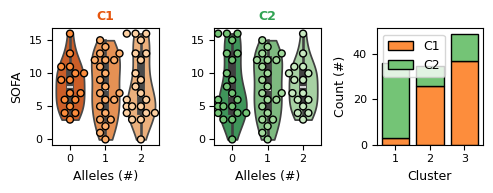

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(5, 2))

sns.swarmplot(data=geno_df, x='C1', y='SOFA', palette=[tabc[5], tabc[6], tabc[7]], edgecolor='k', linewidth=1, ax=ax1)
sns.violinplot(data=geno_df, x='C1', y='SOFA', palette=[tabc[4], tabc[5], tabc[6]], ax=ax1, cut=0)

sns.swarmplot(data=geno_df, x='C2', y='SOFA', palette=[tabc[9], tabc[10], tabc[11]], edgecolor='k', linewidth=1, ax=ax2)
sns.violinplot(data=geno_df, x='C2', y='SOFA', palette=[tabc[8], tabc[9], tabc[10]], ax=ax2, cut=0)

x = [0, 1, 2]
y1 = []
for i in range(3):
    y1.append(len(sns_df[(sns_df.Cluster == i) & (sns_df.C == 1)]))
y2 = []
for i in range(3):
    y2.append(len(sns_df[(sns_df.Cluster == i) & (sns_df.C == 2)]))
ax3.bar(x, y1, color=tabc[5], edgecolor='k', label='C1')
ax3.bar(x, y2, bottom=y1, color=tabc[9], edgecolor='k', label='C2')
ax3.legend()
ax3.set_ylabel('Count (#)')
ax3.set_xticks([0, 1, 2])
ax3.set_xticklabels([1, 2, 3])
ax3.set_xlabel('Cluster')
ax1.set_title('C1', color=tabc[4], fontweight='heavy')
ax2.set_title('C2', color=tabc[8], fontweight='heavy')
ax2.set_ylabel('')
ax1.set_xlabel('Alleles (#)')
ax2.set_xlabel('Alleles (#)')
plt.tight_layout()
plt.savefig('images/Figure6AC.svg')
plt.show()
plt.close()

In [ ]:
a = geno_df[geno_df.C1 == 0].SOFA.values
b = geno_df[geno_df.C1 == 1].SOFA.values
c = geno_df[geno_df.C1 == 2].SOFA.values
f_oneway(a, b, c)

F_onewayResult(statistic=0.03604837293323632, pvalue=0.9646156046475096)

In [ ]:
a = geno_df[geno_df.C2 == 0].SOFA.values
b = geno_df[geno_df.C2 == 1].SOFA.values
c = geno_df[geno_df.C2 == 2].SOFA.values
f_oneway(a, b, c)

F_onewayResult(statistic=0.03604837293323632, pvalue=0.9646156046475096)

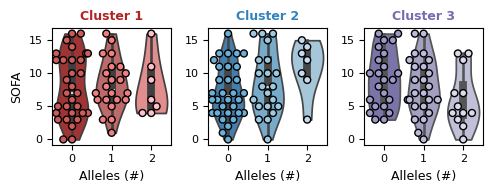

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(5, 2))

sns.swarmplot(data=geno_df, x='CL1', y='SOFA', palette=['indianred', 'lightcoral', 'pink'], edgecolor='k', linewidth=1, ax=ax1)
sns.violinplot(data=geno_df, x='CL1', y='SOFA', palette=['firebrick', 'indianred', 'lightcoral'], ax=ax1, cut=0)

sns.swarmplot(data=geno_df, x='CL2', y='SOFA', palette=[tabc[1], tabc[2], tabc[3]], edgecolor='k', linewidth=1, ax=ax2)
sns.violinplot(data=geno_df, x='CL2', y='SOFA', palette=[tabc[0], tabc[1], tabc[2]], ax=ax2, cut=0)

sns.swarmplot(data=geno_df, x='CL3', y='SOFA', palette=[tabc[13], tabc[14], tabc[15]], edgecolor='k', linewidth=1, ax=ax3)
sns.violinplot(data=geno_df, x='CL3', y='SOFA', palette=[tabc[12], tabc[13], tabc[14]], ax=ax3, cut=0)

ax1.set_title('Cluster 1', color='firebrick', fontweight='heavy')
ax2.set_title('Cluster 2', color=tabc[0], fontweight='heavy')
ax3.set_title('Cluster 3', color=tabc[12], fontweight='heavy')
ax1.set_xlabel('Alleles (#)')
ax2.set_xlabel('Alleles (#)')
ax3.set_xlabel('Alleles (#)')
ax2.set_ylabel('')
ax3.set_ylabel('')
plt.tight_layout()
plt.savefig('images/Figure6DF.svg')
plt.show()
plt.close()

In [ ]:
a = geno_df[geno_df.CL1 == 0].SOFA.values
b = geno_df[geno_df.CL1 == 1].SOFA.values
c = geno_df[geno_df.CL1 == 2].SOFA.values
f_oneway(a, b, c)

F_onewayResult(statistic=0.03888676331176593, pvalue=0.9618851155633887)

In [ ]:
a = geno_df[geno_df.CL2 == 0].SOFA.values
b = geno_df[geno_df.CL2 == 1].SOFA.values
c = geno_df[geno_df.CL2 == 2].SOFA.values
f_oneway(a, b, c)

F_onewayResult(statistic=2.171436623060722, pvalue=0.12335482315211532)

In [ ]:
a = geno_df[geno_df.CL3 == 0].SOFA.values
b = geno_df[geno_df.CL3 == 1].SOFA.values
c = geno_df[geno_df.CL3 == 2].SOFA.values
f_oneway(a, b, c)

F_onewayResult(statistic=1.9270235627631598, pvalue=0.15494714986736596)

In [ ]:
peptide_table = pd.read_pickle('peptide_table.pkl')

In [ ]:
A = pd.read_csv('conditional_effects_A.csv')
B = pd.read_csv('conditional_effects_B.csv')
C = pd.read_csv('conditional_effects_C.csv')
sex = pd.read_csv('conditional_effects_sex.csv')
age = pd.read_csv('conditional_effects_age.csv')
bmi = pd.read_csv('conditional_effects_bmi.csv')
scatter = pd.read_csv('conditional_effects_SOFA.csv')

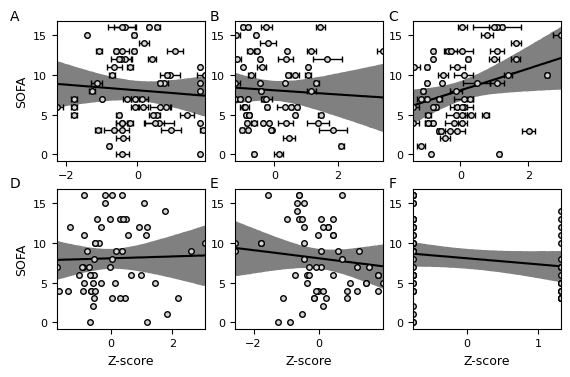

In [ ]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(6.5, 4))

ms = 4

ax1.plot(A.effect1__, A.estimate__, color='k')
ax1.fill_between(A.effect1__, A.lower__, A.upper__, alpha=1, color='grey')
ax1.errorbar(scatter.Am, scatter.y, xerr=scatter.As, fmt='o', color='lightgrey', ms=ms, linewidth=1, capsize=2, ecolor='k', alpha=1, markeredgecolor='k')
ax1.set_xlim([min(A.effect1__), max(A.effect1__)])
#ax1.set_title('HLA-A')

ax2.plot(B.effect1__, B.estimate__, color='k')
ax2.fill_between(B.effect1__, B.lower__, B.upper__, alpha=1, color='grey')
ax2.errorbar(scatter.Bm, scatter.y, xerr=scatter.Bs, fmt='o', color='lightgrey', ms=ms, linewidth=1, capsize=2, ecolor='k', alpha=1, markeredgecolor='k')
ax2.set_xlim([min(B.effect1__), max(B.effect1__)])
#ax2.set_title('HLA-B')

ax3.plot(C.effect1__, C.estimate__, color='k')
ax3.fill_between(C.effect1__, C.lower__, C.upper__, alpha=1, color='grey')
ax3.errorbar(scatter.Cm, scatter.y, xerr=scatter.Cs, fmt='o', color='lightgrey', ms=ms, linewidth=1, capsize=2, ecolor='k', alpha=1, markeredgecolor='k')
ax3.set_xlim([min(C.effect1__), max(C.effect1__)])
#ax3.set_title('HLA-C')

ax4.plot(bmi.effect1__, bmi.estimate__, color='k')
ax4.fill_between(bmi.effect1__, bmi.lower__, bmi.upper__, alpha=1, color='grey')
ax4.errorbar(scatter.BMI, scatter.y, fmt='o', color='lightgrey', ms=ms, linewidth=1, capsize=2, ecolor='k', alpha=1, markeredgecolor='k')
ax4.set_xlim([min(bmi.effect1__), max(bmi.effect1__)])
#ax4.set_title('Age')

ax5.plot(age.effect1__, age.estimate__, color='k')
ax5.fill_between(age.effect1__, age.lower__, age.upper__, alpha=1, color='grey')
ax5.errorbar(scatter.Age, scatter.y, fmt='o', color='lightgrey', ms=ms, linewidth=1, capsize=2, ecolor='k', alpha=1, markeredgecolor='k')
ax5.set_xlim([min(age.effect1__), max(age.effect1__)])
#ax5.set_title('BMI')

ax6.plot(sex.effect1__, sex.estimate__, color='k')
ax6.fill_between(sex.effect1__, sex.lower__, sex.upper__, alpha=1, color='grey')
ax6.errorbar(scatter.Sex, scatter.y, fmt='o', color='lightgrey', ms=ms, linewidth=1, capsize=2, ecolor='k', alpha=1, markeredgecolor='k')
ax6.set_xlim([min(sex.effect1__), max(sex.effect1__)])
#ax6.set_title('Sex (F)')

ax1.set_ylabel('SOFA')
ax4.set_ylabel('SOFA')
ax4.set_xlabel('Z-score')
ax5.set_xlabel('Z-score')
ax6.set_xlabel('Z-score')

plt.text(-6.4, 38, 'A', fontsize=10)
plt.text(-3.6, 38, 'B', fontsize=10)
plt.text(-1.1, 38, 'C', fontsize=10)
plt.text(-6.4, 17, 'D', fontsize=10)
plt.text(-3.6, 17, 'E', fontsize=10)
plt.text(-1.1, 17, 'F', fontsize=10)

plt.tight_layout()
plt.savefig('images/FigureS2.png', dpi=300)
plt.show()
plt.close()

In [ ]:
peptide_dict = nestedDict()
for tq, s in zip(tqdm(range(len(sample_dict))), list(sample_dict)):
    for p in np.arange(0.5, 0.96, 0.01):
        tmp = sample_dict[s]
        peptides = tmp[(tmp.Allele.str.contains('C')) & (tmp.Probability >= p)]['Peptide Sequence']
        peptide_dict[s][p] = peptides

  0%|          | 0/60 [00:00<?, ?it/s]

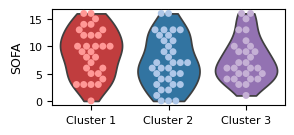

In [ ]:
km_colors = plt.get_cmap('tab20').colors
km_colors1 = [km_colors[6], km_colors[0], km_colors[8]]
km_colors2 = [km_colors[7], km_colors[1], km_colors[9]]

c1 = [km_colors1[x] for x in kmeans.labels_]
c2 = [km_colors2[x] for x in kmeans.labels_]

sec_df = se_df[se_df.Allele.str.contains('C')]
sec_df = sec_df[['Allele', 'SOFA', 'Cluster']].drop_duplicates()
fig, ax = plt.subplots(figsize=(3, 1.25))
sns.violinplot(data=sec_df, y='SOFA', x='Cluster', cut=0, palette=km_colors1, ax=ax, inner=None)
sns.swarmplot(data=sec_df, y='SOFA', x='Cluster', palette=km_colors2, ax=ax)
ax.set_xticklabels(['Cluster 1', 'Cluster 2', 'Cluster 3'])
ax.set_xlabel('')
plt.show()
plt.close()

In [ ]:
DF = pd.read_excel('../../20210919_affinity_predictions2/COVIDdata4.22.2022.xlsx')
DF['Age at admission/diagnosis'] = pd.to_numeric(DF['Age at admission/diagnosis'].replace('.', np.nan))
for c in DF.columns:
    DF[c] = DF[c].replace('Not Applicable', np.nan)
    DF[c] = DF[c].replace('Not applicable', np.nan)
DF = DF[DF.SAMPLE_ID.isin(data.SAMPLE_ID)]

In [ ]:
CLIN = pd.DataFrame(data={
'AGE' : pd.to_numeric(DF['Age at admission/diagnosis']),
'BMI' : pd.to_numeric(DF['BMI']),
'SEX_F' : pd.get_dummies(DF.SEX).Female,
'ICU' : pd.get_dummies(DF.YN_ICU).Y,
'INTUBATED' : pd.get_dummies(DF.YN_Intub).Y,
'SUPPLEMENT_O2' : pd.get_dummies(DF.YN_SUPPLEMENT_O2).Y,
'DECEASED' : pd.get_dummies(DF.ALIVE_AT_DISCHARGE).N,
'MAX_CRP' : DF[['HIGHEST_CRP_3DAY', 'HIGHEST_CRP_7TO10DAY']].max(axis=1),
'MAX_FERRITIN' : DF[['HIGHEST_FERRITIN_3DAY', 'HIGHEST_FERRITIN_7TO10DAY']].max(axis=1),
'MAX_CREATININE' : DF[['HIGHEST_CREATININE_3DAY', 'HIGHEST_CREATININE_7TO10DAY']].max(axis=1),
'MAX_WBC' : DF[['HIGHEST_WBC_3DAY', 'HIGHEST_WBC_7TO10DAY']].max(axis=1),
'MIN_WBC' : DF[['LOWEST_WBC_3DAY', 'LOWEST_WBC_7TO10DAY']].min(axis=1),
'MIN_HEMOGLOBIN' : DF[['LOWEST_HB_3DAY', 'LOWEST_HB_7TO10DAY']].min(axis=1),
'MAX_PLATELET' : DF[['HIGHEST_PLATELET_3DAY', 'HIGHEST_PLATELET_7TO10DAY']].max(axis=1),
'MIN_PLATELET': DF[['LOWEST_PLATELET_3DAY', 'LOWEST_PLATELET_7TO10DAY']].min(axis=1),
'MAX_SOFA' : DF[['HIGHEST_SOFA_3DAY', 'HIGHEST_SOFA_7TO10DAY']].max(axis=1)
})
CLIN

,AGE,BMI,SEX_F,ICU,INTUBATED,SUPPLEMENT_O2,DECEASED,MAX_CRP,MAX_FERRITIN,MAX_CREATININE,MAX_WBC,MIN_WBC,MIN_HEMOGLOBIN,MAX_PLATELET,MIN_PLATELET,MAX_SOFA
1,52.0,27.77,False,True,True,True,False,33.0,8247.5,7.21,12.8,2.0,6.9,312.0,80.0,13.0
5,59.0,32.10,True,True,True,True,False,53.4,2078.2,1.20,20.0,11.1,4.0,373.0,165.0,8.0
6,57.0,30.14,False,True,True,True,False,36.6,3981.0,6.81,26.4,13.2,3.1,271.0,126.0,16.0
8,65.0,26.07,True,True,False,True,False,17.7,1518.0,0.77,8.3,6.0,10.4,289.0,240.0,4.0
10,77.0,NaN,True,True,False,True,False,11.5,203.8,0.75,7.9,7.5,11.5,510.0,233.0,4.0
11,63.0,35.77,True,True,False,True,False,15.5,1897.7,1.12,7.8,6.2,12.6,252.0,186.0,3.0
14,53.0,25.64,False,True,False,True,False,35.8,1113.5,0.99,11.3,6.6,11.8,358.0,183.0,0.0
19,58.0,48.05,False,True,False,True,False,5.9,316.3,1.05,6.6,3.3,10.8,397.0,182.0,1.0
25,44.0,23.91,False,True,True,True,False,33.1,2049.2,5.20,28.4,17.7,10.3,405.0,165.0,16.0
28,59.0,27.16,False,True,True,True,False,16.2,1219.4,0.92,14.9,3.8,13.0,345.0,170.0,10.0


In [ ]:
CLIN.columns = ['Age', 'BMI', 'Sex (F)', 'Admitted to ICU', 'Intubated', 'Supplemental O2', 'Deceased', 'Max CRP', 'Max Ferritin', 'Max Creatinine', 'Max WBC', 'Min WBC', 'Min Hemoglobin', 'Max Platelet', 'Min Platelet', 'Max SOFA']

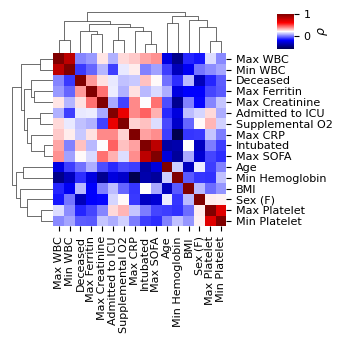

In [ ]:
sns.clustermap(CLIN.corr(), cmap='seismic', figsize=(3.5, 3.5), cbar_kws={'label' : r'$\rho$'}, cbar_pos=[0.80, 0.85, .05, .1])
#plt.text(-7.4, 1, 'A')
plt.tight_layout()
plt.savefig('./images/FigureS1.png', dpi=300)
plt.show()
plt.close()

In [ ]:
CLIN.corr()['MAX_SOFA'].sort_values()

MIN_HEMOGLOBIN   -0.385575
SEX_F            -0.266274
AGE              -0.245226
MIN_PLATELET     -0.101475
MAX_PLATELET     -0.060908
MIN_WBC           0.076175
BMI               0.087224
MAX_FERRITIN      0.161302
SUPPLEMENT_O2     0.171094
DECEASED          0.229788
ICU               0.336078
MAX_WBC           0.385714
MAX_CRP           0.394515
MAX_CREATININE    0.434025
INTUBATED         0.812780
MAX_SOFA          1.000000
Name: MAX_SOFA, dtype: float64